# ANALYSIS OF ALL MOVIES

In [1]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from collections import Counter, defaultdict
import community.community_louvain as community_louvain
import numpy as np
import re
import math
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nerea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## TOP MOVIES!
Create directed network with the top 250 and their related movies.

In [4]:
# Load the CSV file into a DataFrame
df = pd.read_csv('C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/FinalProject/csv/top_movie_data_with_similar.csv')

# Create an empty directed graph
D1 = nx.DiGraph()

# Add nodes and edges based on the similarity list
for index, row in df.iterrows():
    film = row['Name']
    similar_films = row['Similar Movies'].split(', ')  # Splitting the similar films into a list
    
    # Add the film as a node (it will be added automatically when creating edges)
    D1.add_node(film)
    
    # Add edges between the film and its similar films
    for similar_film in similar_films:
        D1.add_edge(film, similar_film)

# Delete self-loops
self_loops = list(nx.selfloop_edges(D1))
D1.remove_edges_from(self_loops)

# Num of nodes and edges
print("Number of nodes:", D1.number_of_nodes())
print("Number of edges:", D1.number_of_edges())

Number of nodes: 646
Number of edges: 3022


Add metadata to each node as attribute.

In [6]:
# Folder containing the text files
metadata_folder = 'C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/net_movies_info/net_movies_info'

# Function to parse a metadata text file and exclude the "Synopsis" field
def parse_metadata(file_path):
    metadata = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        key = None
        for line in lines:
            line = line.strip()
            if line.endswith(':'):
                key = line[:-1]  # Remove the colon
                if key == 'Synopsis':  # Skip "Synopsis"
                    key = None
                else:
                    metadata[key] = ''
            elif key:  # Append the value to the current key
                metadata[key] += (' ' + line if metadata[key] else line)
    return metadata

# Add metadata to the nodes in the graph
for node in D1.nodes():
    # First, assume the filename matches the node title directly
    metadata_file = os.path.join(metadata_folder, f"{node}.txt")
    
    # If the file doesn't exist, try replacing ":" and "?" with "_"
    if not os.path.exists(metadata_file):
        if node == "Car Crash: Who's Lying?":
            sanitized_node = "Car Crash_ Who's Lying_"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
        else:
            for char in [':', '?']:
                sanitized_node = node.replace(char, '_')
                metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
                if os.path.exists(metadata_file):
                    break
    
    # If the file exists, parse the metadata and add it to the node
    if os.path.exists(metadata_file):
        metadata = parse_metadata(metadata_file)
        nx.set_node_attributes(D1, {node: metadata})
    else:
        print(f"Metadata file not found for {node}")

In [7]:
# Check attributes of a specific node
sample_node = "Fight Club"
if sample_node in D1.nodes:
    # Print the metadata of the node in one line each
    for key, value in D1.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: Fight Club 
Rating: 8.8 
Top 250 Rank: 13 
Duration: 139 
Release Date: 05 Nov 1999 (Denmark) 
Genres: Drama 
Director: David Fincher 
Actors: Edward Norton, Brad Pitt, Meat Loaf, Zach Grenier, Richmond Arquette, David Andrews, George Maguire, Eugenie Bondurant, Christina Cabot, Helena Bonham Carter 
Languages: English 
Description: A nameless first-person narrator attends support groups in an attempt to subdue his emotional state and relieve his insomniac state. When he meets Marla, another fake attendee of support groups, his life seems to become a little more bearable. However, when he associates himself with Tyler he is dragged into an underground fight club and soap-making scheme. Together the two men spiral out of control and engage in competitive rivalry for love and power. 
Plot: ['An insomniac office worker and a devil-may-care soap maker form an underground fight club that evolves into much more.', 'A nameless first-person narrator attends support groups in an attempt 

Keep only movies with a **rating greater than 7.8**. This will help expand the network and increase connectivity, as the top 250 movies start at a minimum rating of 8.

In [8]:
# Take only the movies with more than 7.8 rating
nodes_to_remove = []
for node in D1.nodes():
    if 'Rating' in D1.nodes[node]:
        rating = D1.nodes[node]['Rating']
        if rating:
            if rating == 'N/A ':
                nodes_to_remove.append(node)
            else:
                rating = float(rating)
                if rating < 7.8:
                    nodes_to_remove.append(node)

D2 = D1.copy()
D2.remove_nodes_from(nodes_to_remove)
print("Number of nodes after removing:", D2.number_of_nodes())
print("Number of edges after removing:", D2.number_of_edges())

Number of nodes after removing: 395
Number of edges after removing: 2478


Keep only the largest connected component.

Number of nodes: 391
Number of edges: 2478


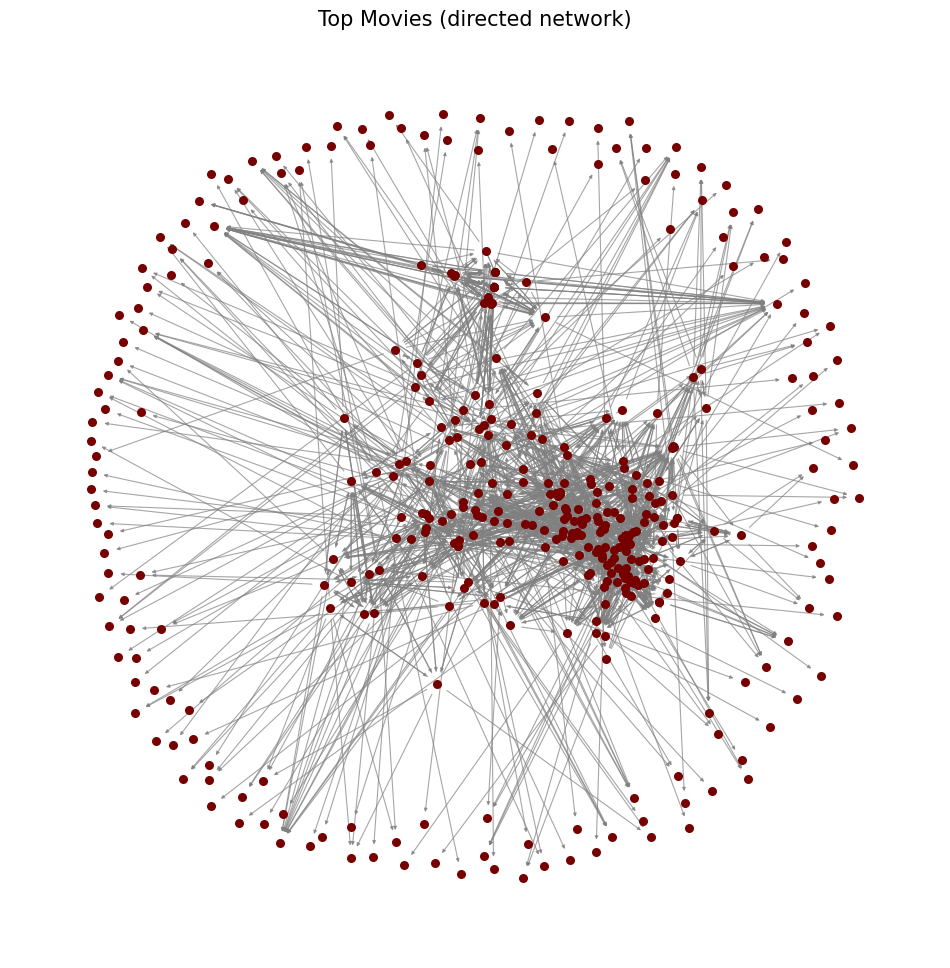

In [9]:
# Take the largest connected component
largest_cc = max(nx.weakly_connected_components(D2), key=len)
D = D2.subgraph(largest_cc)

# Num of nodes and edges
print("Number of nodes:", D.number_of_nodes())
print("Number of edges:", D.number_of_edges())

# Plot the graph
plt.figure(figsize=(12, 12))

# Positions for nodes
pos = nx.spring_layout(D, seed=42)  # Layout for consistent

# Draw edges and nodes
nx.draw_networkx_edges(D, pos, edge_color='gray', alpha=0.7, width=0.8, arrowsize=5)
nx.draw_networkx_nodes(D, pos, node_color='#760000', node_size=30)

plt.title('Top Movies (directed network)', fontsize=15)
plt.axis('off')
plt.show()

Save all node names in a txt.

<div class="alert alert-warning">
DONT RUN AGAIN!
</div>

In [126]:
# Save node names to a text file
node_names = list(D.nodes)
with open('top_net_movies_titles.txt', 'w') as file:
    for node in node_names:
        file.write(f"{node}\n")

print(f"Node names have been saved.")

Node names have been saved.


### Distributions
We calculate the out and in degree distributions of the network.

Text(0, 0.5, 'Frequency')

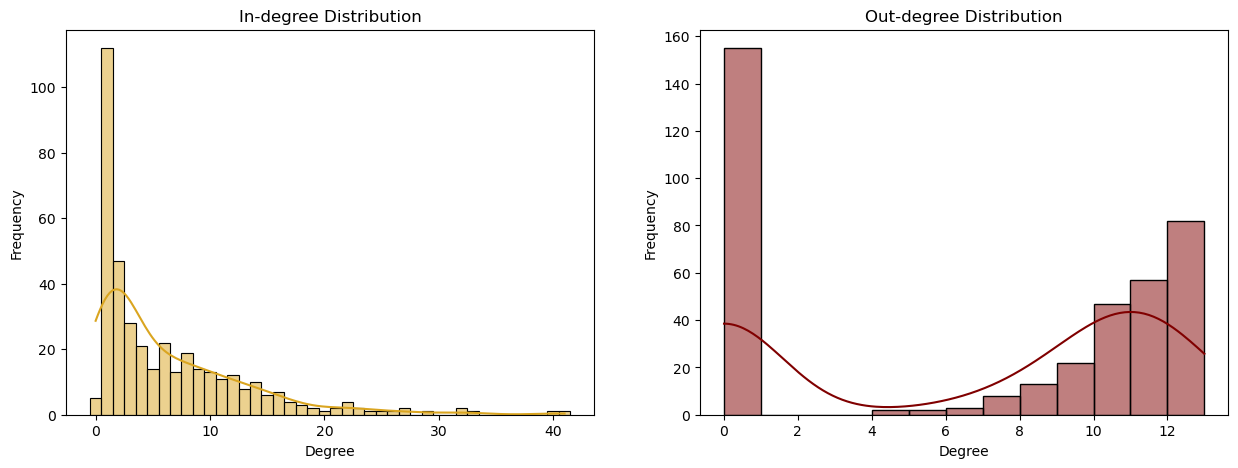

In [10]:
# Get the in-degree and out-degree for each node
in_degrees = [d for n, d in D.in_degree()]
out_degrees = [d for n, d in D.out_degree()]

# Create a pandas Series from the degree lists
in_degree_series = pd.Series(in_degrees)
out_degree_series = pd.Series(out_degrees)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define bin width and range
binwidth = 1
binrange = (min(in_degrees) - 0.5, max(in_degrees) + 0.5)

# Plot the in-degree distribution as a histogram in the first subplot
sns.histplot(in_degree_series, color='goldenrod', kde=True, ax=ax1, binwidth=binwidth, binrange=binrange)
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")

# Plot the out-degree distribution as a histogram in the second subplot
sns.histplot(out_degree_series, color='maroon', kde=True, ax=ax2, binwidth=binwidth)
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency")

Some nodes have a zero out-degree because the related movies that are not part of the original top 250 do not have any edges pointing to other nodes, only the top 250 movies have outgoing edges. 
To refine the analysis, we will remove all nodes with a zero out-degree.

Removing 155 nodes with out-degree = 0


Text(0, 0.5, 'Frequency')

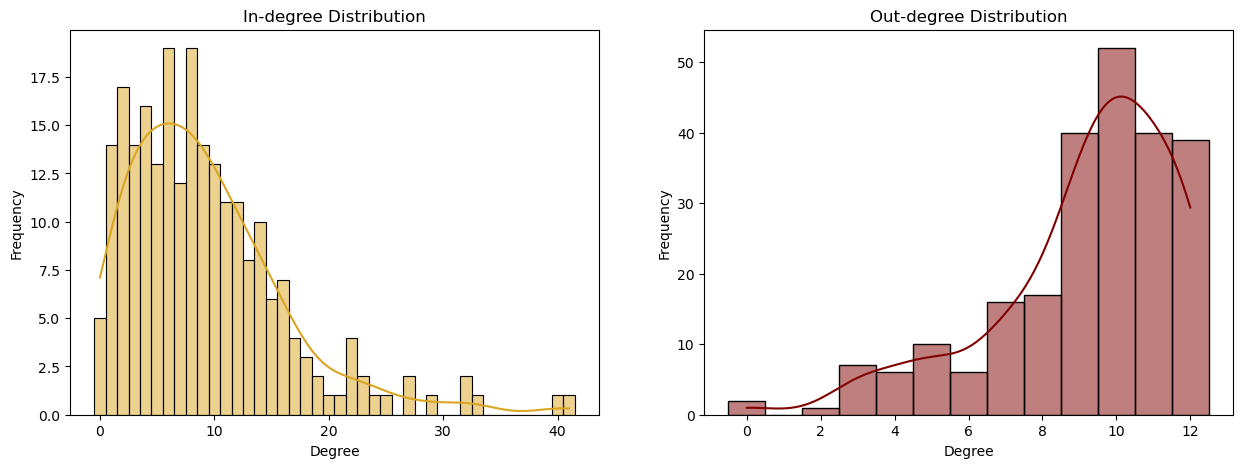

In [11]:
# Make a copy of the graph
H = D.copy()

# Remove the nodes with out-degree = 0
nodes_to_remove = [node for node, out_degree in dict(H.out_degree()).items() if out_degree == 0]
print(f"Removing {len(nodes_to_remove)} nodes with out-degree = 0")
H.remove_nodes_from(nodes_to_remove)

# Get the in-degree and out-degree for each node
in_degrees = [d for n, d in H.in_degree()]
out_degrees = [d for n, d in H.out_degree()]

# Create a pandas Series from the degree lists
in_degree_series = pd.Series(in_degrees)
out_degree_series = pd.Series(out_degrees)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define bin width and range
binwidth = 1
binrange = (min(in_degrees) - 0.5, max(in_degrees) + 0.5)

# Plot the in-degree distribution as a histogram in the first subplot
sns.histplot(in_degree_series, color='goldenrod', kde=True, ax=ax1, binwidth=binwidth, binrange=binrange)
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")

# Define bin range for out-degrees
binrange = (min(out_degrees) - 0.5, max(out_degrees) + 0.5)

# Plot the out-degree distribution as a histogram in the second subplot
sns.histplot(out_degree_series, color='maroon', kde=True, ax=ax2, binwidth=binwidth, binrange=binrange)
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency")

Print top 5 in and out-degree movies.

In [12]:
# Top 5 nodes with highest in-degree with its genre and rating
in_degrees = dict(H.in_degree())
top_5_indegree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes with highest in-degree:")
for node, indegree in top_5_indegree:
    print(f"{node} (In-degree: {indegree})")
    print(f"    Genres: {H.nodes[node].get('Genres')}")
    print(f"    Rating: {H.nodes[node].get('Rating')}")
    print(F"    Director: {H.nodes[node].get('Director')}")
    print(F"    Cast: {H.nodes[node].get('Actors')}")

Top 5 nodes with highest in-degree:
Fight Club (In-degree: 41)
    Genres: Drama 
    Rating: 8.8 
    Director: David Fincher 
    Cast: Edward Norton, Brad Pitt, Meat Loaf, Zach Grenier, Richmond Arquette, David Andrews, George Maguire, Eugenie Bondurant, Christina Cabot, Helena Bonham Carter 
Forrest Gump (In-degree: 40)
    Genres: Drama, Romance 
    Rating: 8.8 
    Director: Robert Zemeckis 
    Cast: Tom Hanks, Rebecca Williams, Sally Field, Michael Conner Humphreys, Harold G. Herthum, George Kelly, Bob Penny, John Randall, Sam Anderson, Margo Moorer 
Pulp Fiction (In-degree: 33)
    Genres: Crime, Drama 
    Rating: 8.9 
    Director: Quentin Tarantino 
    Cast: Tim Roth, Amanda Plummer, Laura Lovelace, John Travolta, Samuel L. Jackson, Phil LaMarr, Frank Whaley, Burr Steers, Bruce Willis, Ving Rhames 
Inception (In-degree: 32)
    Genres: Action, Adventure, Sci-Fi, Thriller 
    Rating: 8.8 
    Director: Christopher Nolan 
    Cast: Leonardo DiCaprio, Joseph Gordon-Levitt, 

In [13]:
# Top 5 nodes with highest out-degree with its genre and rating
out_degrees = dict(H.out_degree())
top_5_outdegree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes with highest out-degree:")
for node, outdegree in top_5_outdegree:
    print(f"{node} (Out-degree: {outdegree})")
    print(f"    Genres: {H.nodes[node].get('Genres')}")
    print(f"    Rating: {H.nodes[node].get('Rating')}")
    print(F"    Director: {H.nodes[node].get('Director')}")
    print(F"    Cast: {H.nodes[node].get('Actors')}")

Top 5 nodes with highest out-degree:
The Shawshank Redemption (Out-degree: 12)
    Genres: Drama 
    Rating: 9.3 
    Director: Frank Darabont 
    Cast: Tim Robbins, Morgan Freeman, Bob Gunton, William Sadler, Clancy Brown, Gil Bellows, Mark Rolston, James Whitmore, Jeffrey DeMunn, Larry Brandenburg 
Forrest Gump (Out-degree: 12)
    Genres: Drama, Romance 
    Rating: 8.8 
    Director: Robert Zemeckis 
    Cast: Tom Hanks, Rebecca Williams, Sally Field, Michael Conner Humphreys, Harold G. Herthum, George Kelly, Bob Penny, John Randall, Sam Anderson, Margo Moorer 
Fight Club (Out-degree: 12)
    Genres: Drama 
    Rating: 8.8 
    Director: David Fincher 
    Cast: Edward Norton, Brad Pitt, Meat Loaf, Zach Grenier, Richmond Arquette, David Andrews, George Maguire, Eugenie Bondurant, Christina Cabot, Helena Bonham Carter 
Pulp Fiction (Out-degree: 12)
    Genres: Crime, Drama 
    Rating: 8.9 
    Director: Quentin Tarantino 
    Cast: Tim Roth, Amanda Plummer, Laura Lovelace, John T

### Communities
First, we make the network undirected.

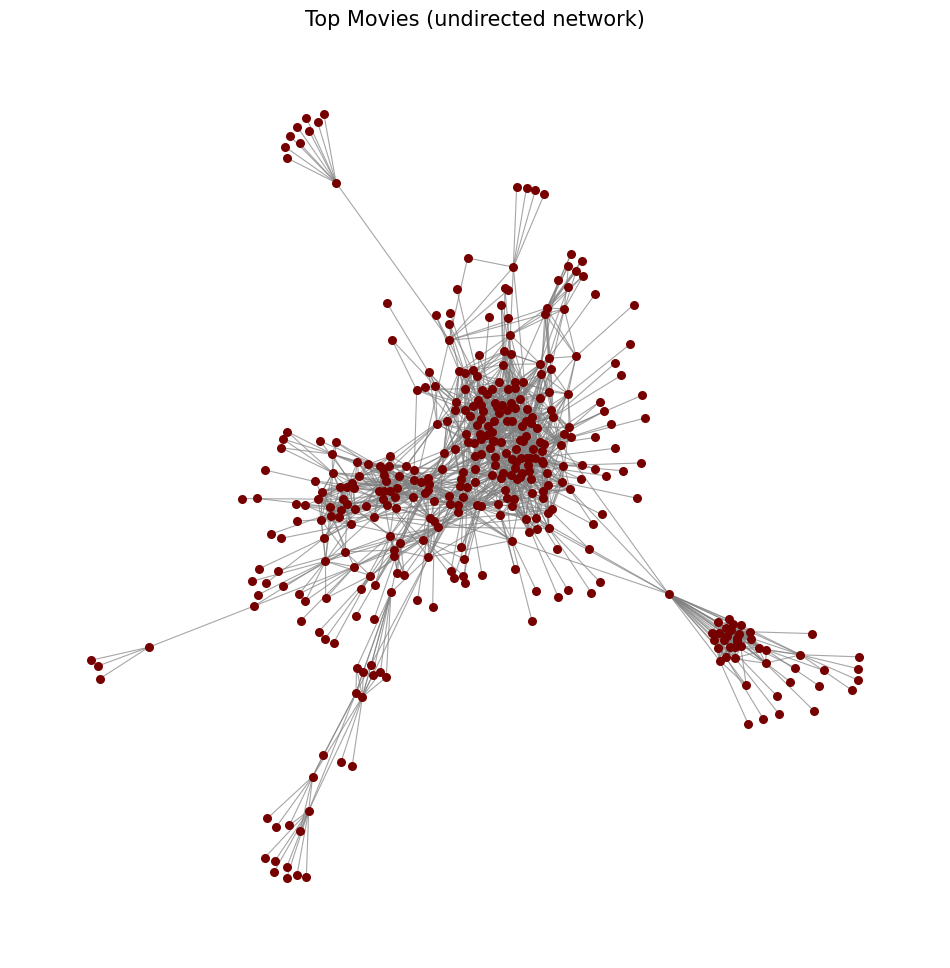

In [14]:
# Make undirected graph
G = D.to_undirected()

# Plot the graph
plt.figure(figsize=(12, 12))

# Positions for nodes
pos = nx.spring_layout(G, seed=42)  # Layout for consistent

# Draw edges and nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.7, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color='#760000', node_size=30)

plt.title('Top Movies (undirected network)', fontsize=15)
plt.axis('off')
plt.show()

In [15]:
# Check if the undirected graph has still attributes
sample_node = "Fight Club"
if sample_node in G.nodes:
    # Print the metadata of the node in one line each
    for key, value in G.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: Fight Club 
Rating: 8.8 
Top 250 Rank: 13 
Duration: 139 
Release Date: 05 Nov 1999 (Denmark) 
Genres: Drama 
Director: David Fincher 
Actors: Edward Norton, Brad Pitt, Meat Loaf, Zach Grenier, Richmond Arquette, David Andrews, George Maguire, Eugenie Bondurant, Christina Cabot, Helena Bonham Carter 
Languages: English 
Description: A nameless first-person narrator attends support groups in an attempt to subdue his emotional state and relieve his insomniac state. When he meets Marla, another fake attendee of support groups, his life seems to become a little more bearable. However, when he associates himself with Tyler he is dragged into an underground fight club and soap-making scheme. Together the two men spiral out of control and engage in competitive rivalry for love and power. 
Plot: ['An insomniac office worker and a devil-may-care soap maker form an underground fight club that evolves into much more.', 'A nameless first-person narrator attends support groups in an attempt 

#### Genre partition

Group nodes based on their **genres**. Nodes without any genre information will be assigned to a "None" category.

In [16]:
# Create a dictionary to hold the partition
genre_partition = {}

# Iterate over nodes in the graph and assign them to communities based on their first genre
for node, data in G.nodes(data=True):
    # Get the 'Genres' attribute and split it into a list, if present
    genres = data.get("Genres", "")  # Default to an empty string if 'Genres' is missing
    genres_list = [g.strip() for g in genres.split(",")] if genres else []  # Split and strip spaces
    
    # Get the first genre, or None if no genres are available
    first_genre = genres_list[0] if genres_list else None
    
    # Add node to the appropriate community in the partition
    if first_genre not in genre_partition:
        genre_partition[first_genre] = []
    genre_partition[first_genre].append(node)

print("Total number of genres:", len(genre_partition), "\n")
for genre, nodes in genre_partition.items():
    print(f"{genre}: {len(nodes)} nodes")

Total number of genres: 12 

Drama: 99 nodes
Action: 78 nodes
Crime: 46 nodes
Biography: 30 nodes
Adventure: 25 nodes
Comedy: 42 nodes
Short: 7 nodes
Animation: 46 nodes
Mystery: 3 nodes
Horror: 3 nodes
Documentary: 10 nodes
Film-Noir: 2 nodes


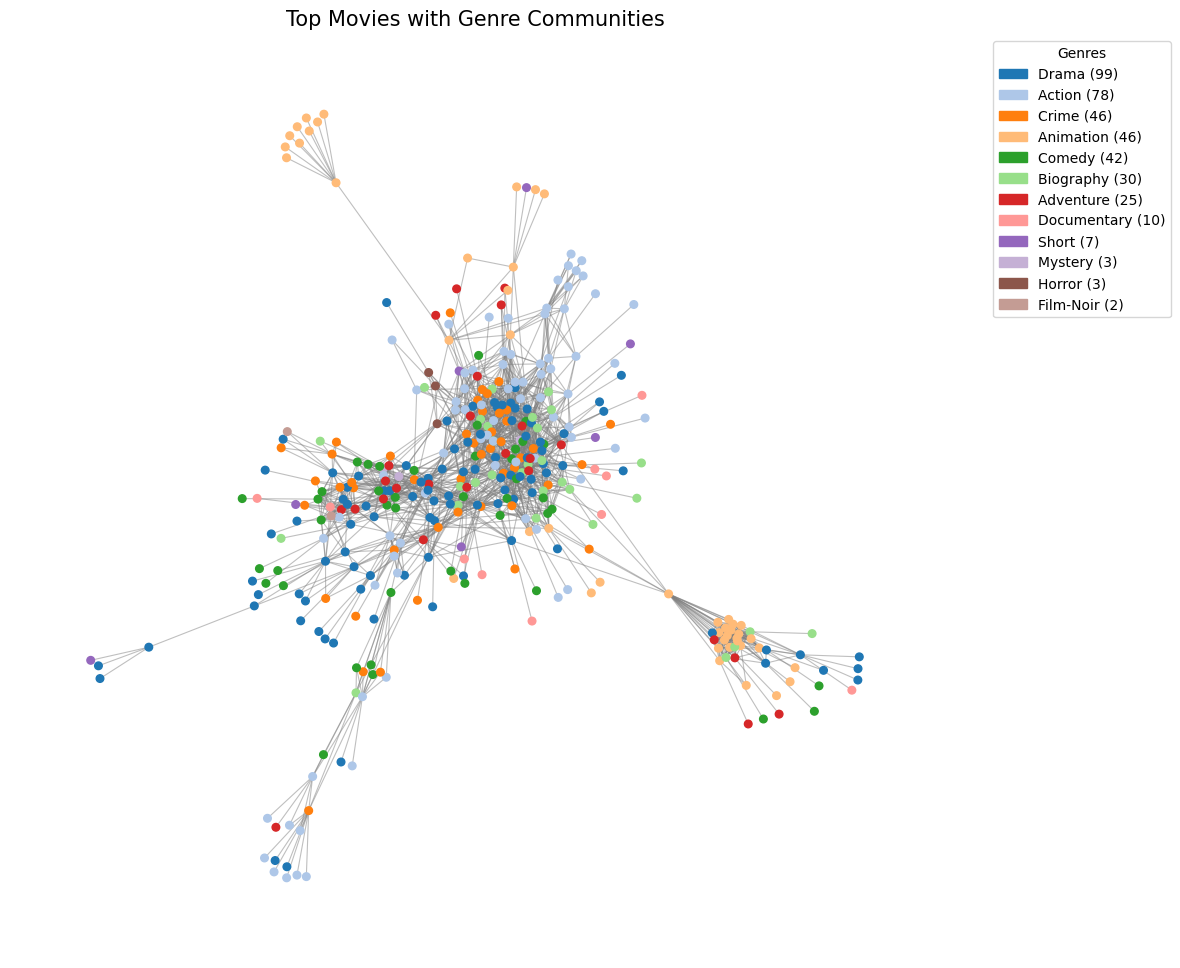

In [17]:
# Sort genres by the number of nodes, descending
sorted_genres = sorted(genre_partition.items(), key=lambda x: len(x[1]), reverse=True)

# Create a color map for each genre based on the sorted order
genre_to_color = {genre: plt.cm.tab20.colors[i % 20] for i, (genre, _) in enumerate(sorted_genres)}

# Create a list of colors for the nodes based on their genre
node_colors = []
for node in G.nodes:
    # Assign the corresponding color, default to "Unknown"
    assigned_color = "gray"  # Default to gray for nodes not matching any genre
    for genre, nodes in genre_partition.items():
        if node in nodes:
            assigned_color = genre_to_color[genre]
            break
    node_colors.append(assigned_color)

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Layout for consistent positioning

nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30)

# Create a sorted legend
legend_handles = [
    mpatches.Patch(color=genre_to_color[genre], label=f"{genre} ({len(nodes)})")
    for genre, nodes in sorted_genres
]
plt.legend(handles=legend_handles, title="Genres", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("Top Movies with Genre Communities", fontsize=15)

plt.axis("off")
plt.show()


Calculate the **modularity** of the genre-based partition.

In [18]:
# Calculate L (total links) in the entire network
L = G.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_genre = 0
for community in genre_partition.values():
    subgraph = G.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_genre += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the genre-based partition (formula book):", modularity_genre)

Modularity of the genre-based partition (formula book): 0.3161048406139315


In [19]:
# Modularity using NetworkX
modularity_genre2 = nx.algorithms.community.modularity(G, [set(nodes) for nodes in genre_partition.values()])
print("Modularity of the genre-based partition (networkX formula):", modularity_genre2)

Modularity of the genre-based partition (networkX formula): 0.18073226513745994


#### Director partition
Group nodes based on their **director**. Nodes without any genre information will be assigned to a "None" category.

In [20]:
# Create a dictionary to hold the partition
director_partition = {}

# Iterate over nodes in the graph and assign them to communities based on their first genre
for node, data in G.nodes(data=True):
    # Get the 'Directors' attribute and split it into a list, if present
    directors = data.get("Director", "")  # Default to an empty string if 'Genres' is missing
    directors_list = [g.strip() for g in directors.split(",")] if directors else []  # Split and strip spaces
    
    # Get the first genre, or None if no genres are available
    first_director = directors_list[0] if directors_list else None
    
    # Add node to the appropriate community in the partition
    if first_director not in director_partition:
        director_partition[first_director] = []
    director_partition[first_director].append(node)

print("Total number of directors:", len(director_partition), "\n")
for director, nodes in director_partition.items():
    print(f"{director}: {len(nodes)} nodes")

Total number of directors: 206 

Frank Darabont: 2 nodes
Christopher Nolan: 9 nodes
Francis Ford Coppola: 3 nodes
Robert Zemeckis: 3 nodes
David Fincher: 3 nodes
Quentin Tarantino: 8 nodes
Steven Spielberg: 7 nodes
Peter Jackson: 5 nodes
Sidney Lumet: 3 nodes
Martin Scorsese: 8 nodes
Jonathan Demme: 1 nodes
Lana Wachowski: 1 nodes
None: 28 nodes
Roman Polanski: 3 nodes
Irvin Kershner: 1 nodes
Milos Forman: 2 nodes
Vidhu Vinod Chopra: 1 nodes
Rajkumar Hirani: 3 nodes
Nithilan Saminathan: 1 nodes
Nitesh Tiwari: 2 nodes
Kiran Rao: 1 nodes
T.J. Gnanavel: 1 nodes
Nadine Labaki: 1 nodes
Nishikant Kamat: 1 nodes
Pete Docter: 4 nodes
Roberto Benigni: 1 nodes
Richard Marquand: 1 nodes
J.J. Abrams: 1 nodes
Sudha Kongara: 1 nodes
Lokesh Kanagaraj: 2 nodes
Vetrimaaran: 1 nodes
Hanu Raghavapudi: 1 nodes
Gayatri: 1 nodes
C. Prem Kumar: 1 nodes
Prashanth Neel: 1 nodes
Ram Kumar: 1 nodes
James Cameron: 3 nodes
Joaquim Dos Santos: 1 nodes
Jon Watts: 1 nodes
Anthony Russo: 3 nodes
Denis Villeneuve: 5 no

Assign unique colors to the top 20 directors in the plot. All other directors will be grouped into a single "Others" category, displayed in gray.

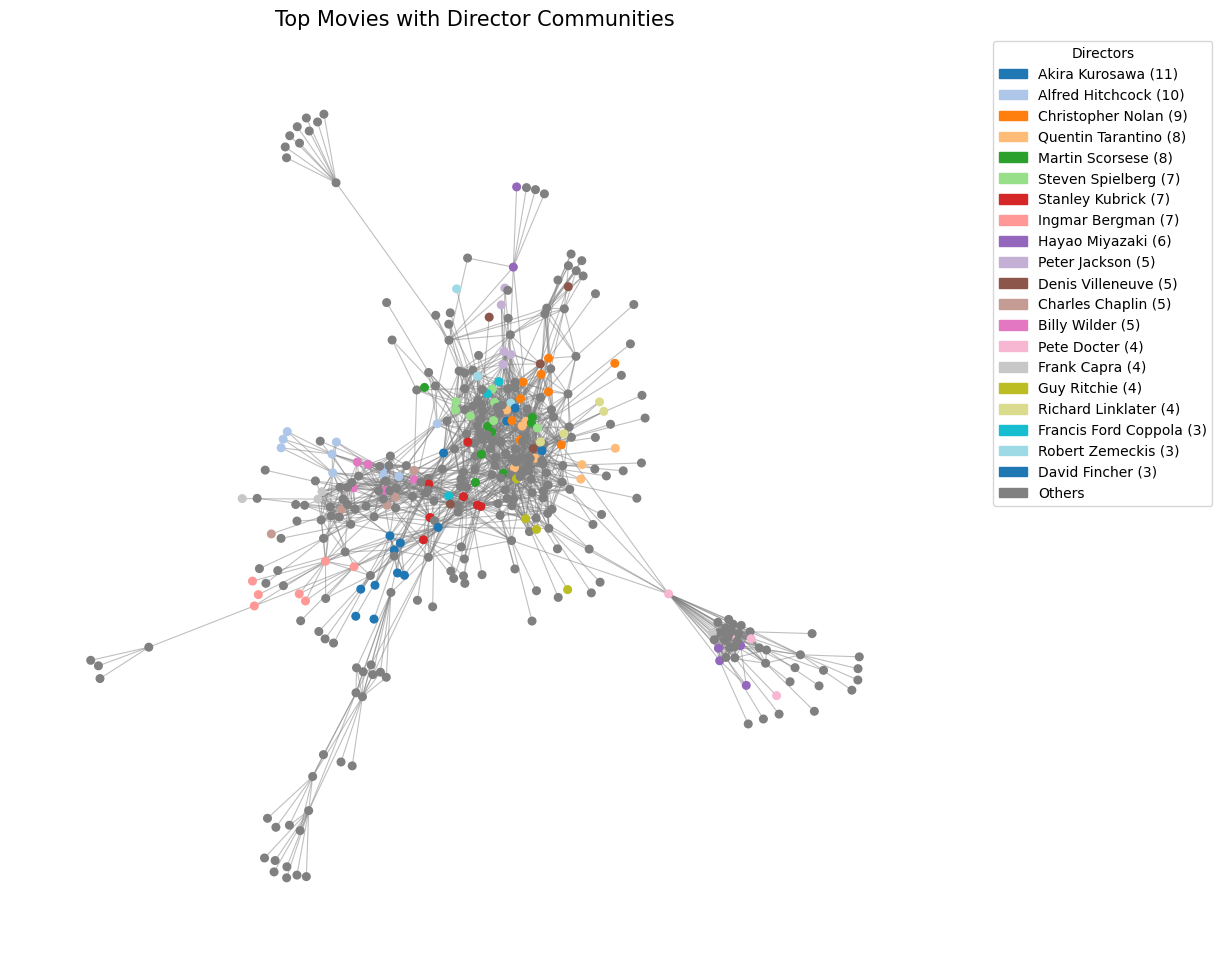

In [21]:
# Get the top 20 directors based on the number of movies (nodes), excluding 'None' or missing directors
top_20_directors = sorted(
    [(director, nodes) for director, nodes in director_partition.items() if director != "None" and director is not None],
    key=lambda x: len(x[1]), reverse=True
)[:20]

# Create a color map for the top 20 directors, excluding the gray color from tab20
tab20_colors = list(plt.cm.tab20.colors)  # Get all 20 colors
tab20_colors.remove(plt.cm.tab20.colors[14])  # Remove the gray color (index 14 in tab20)

# Create a color map for the top 20 directors using the remaining colors
director_to_color = {director: tab20_colors[i % len(tab20_colors)] for i, (director, _) in enumerate(top_20_directors)}

# Add a color for "Others" category using gray
others_color = 'gray'

# Create a list to store the color of each node based on its director
node_colors = []
for node in G.nodes:
    # Find the director of the current node by checking the partition_director dictionary
    assigned_color = others_color  # Default to "Others" for nodes without a top 20 director
    director = None  # Initialize to None (missing director)
    
    # Check the director partition and see if the node has a director
    for dir, nodes in director_partition.items():
        if node in nodes:
            director = dir
            break
    
    if director == "None" or director is None:  # If director is "None" or missing, assign to "Others"
        assigned_color = others_color
    elif director in director_to_color:  # If director is in top 20, assign the corresponding color
        assigned_color = director_to_color[director]
    else:  # If director is not in top 20, assign to "Others"
        assigned_color = others_color

    node_colors.append(assigned_color)

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Layout for consistent positioning

# Draw the edges and nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30)

# Create a legend for the top 20 directors and "Others"
legend_handles = [
    mpatches.Patch(color=director_to_color[director], label=f"{director} ({len(nodes)})")
    for director, nodes in top_20_directors
]
legend_handles.append(mpatches.Patch(color=others_color, label="Others"))

# Add the legend
plt.legend(handles=legend_handles, title="Directors", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add title
plt.title("Top Movies with Director Communities", fontsize=15)

# Remove axis
plt.axis('off')

# Display the plot
plt.show()


Calculate **modularity** of the director based communities.

In [22]:
# Calculate L (total links) in the entire network
L = G.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_director = 0
for community in director_partition.values():
    subgraph = G.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_director += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the director-based partition (formula book):", modularity_director)

Modularity of the director-based partition (formula book): 0.11516545791870468


In [23]:
# Modularity using NetworkX
modularity_director2 = nx.algorithms.community.modularity(G, [set(nodes) for nodes in director_partition.values()])
print("Modularity of the director-based partition (networkX formula):", modularity_director2)

Modularity of the director-based partition (networkX formula): 0.1020872322482712


#### Actors partition

In [24]:
# Create a dictionary to hold the partition
actor_partition = {}

# Iterate over nodes in the graph and assign them to communities based on their first actor
for node, data in G.nodes(data=True):
    # Get the 'Actors' attribute and split it into a list, if present
    actors = data.get("Actors", "")  # Default to an empty string if 'Actors' is missing
    actors_list = [g.strip() for g in actors.split(",")] if actors else []  # Split and strip spaces
    
    # Get the first actor, or None if no actors are available
    first_actor = actors_list[0] if actors_list else None
    
    # Add node to the appropriate community in the partition
    if first_actor not in actor_partition:
        actor_partition[first_actor] = []
    actor_partition[first_actor].append(node)

# Output the partition information
print("Total number of actors:", len(actor_partition), "\n")
for actor, nodes in actor_partition.items():
    print(f"{actor}: {len(nodes)} nodes")

Total number of actors: 282 

Tim Robbins: 1 nodes
Christian Bale: 3 nodes
Marlon Brando: 3 nodes
Tom Hanks: 6 nodes
Edward Norton: 2 nodes
Tim Roth: 1 nodes
Leonardo DiCaprio: 5 nodes
Liam Neeson: 1 nodes
Morgan Freeman: 1 nodes
Noel Appleby: 1 nodes
Al Pacino: 3 nodes
Martin Balsam: 1 nodes
Robert De Niro: 6 nodes
Jodie Foster: 1 nodes
Alan Howard: 1 nodes
Keanu Reeves: 1 nodes
Freddie Highmore: 1 nodes
Adrien Brody: 1 nodes
Bruce Allpress: 1 nodes
Mark Hamill: 3 nodes
Ian McKellen: 2 nodes
Michael Berryman: 1 nodes
Jamie Foxx: 2 nodes
Brad Pitt: 1 nodes
Ellen Burstyn: 3 nodes
Hugh Jackman: 4 nodes
Peter Barbour: 1 nodes
Vikrant Massey: 1 nodes
Aamir Khan: 4 nodes
Vijay Sethupathi: 3 nodes
Nitanshi Goel: 1 nodes
Suriya: 2 nodes
Zain Al Rafeea: 1 nodes
Ajay Devgn: 1 nodes
John Goodman: 2 nodes
Roberto Benigni: 1 nodes
Harrison Ford: 4 nodes
Michael J. Fox: 2 nodes
Kamal Haasan: 1 nodes
Karthi: 1 nodes
Dhanush: 1 nodes
Dulquer Salmaan: 1 nodes
Madhavan: 1 nodes
Yash: 1 nodes
Vishnu Vis

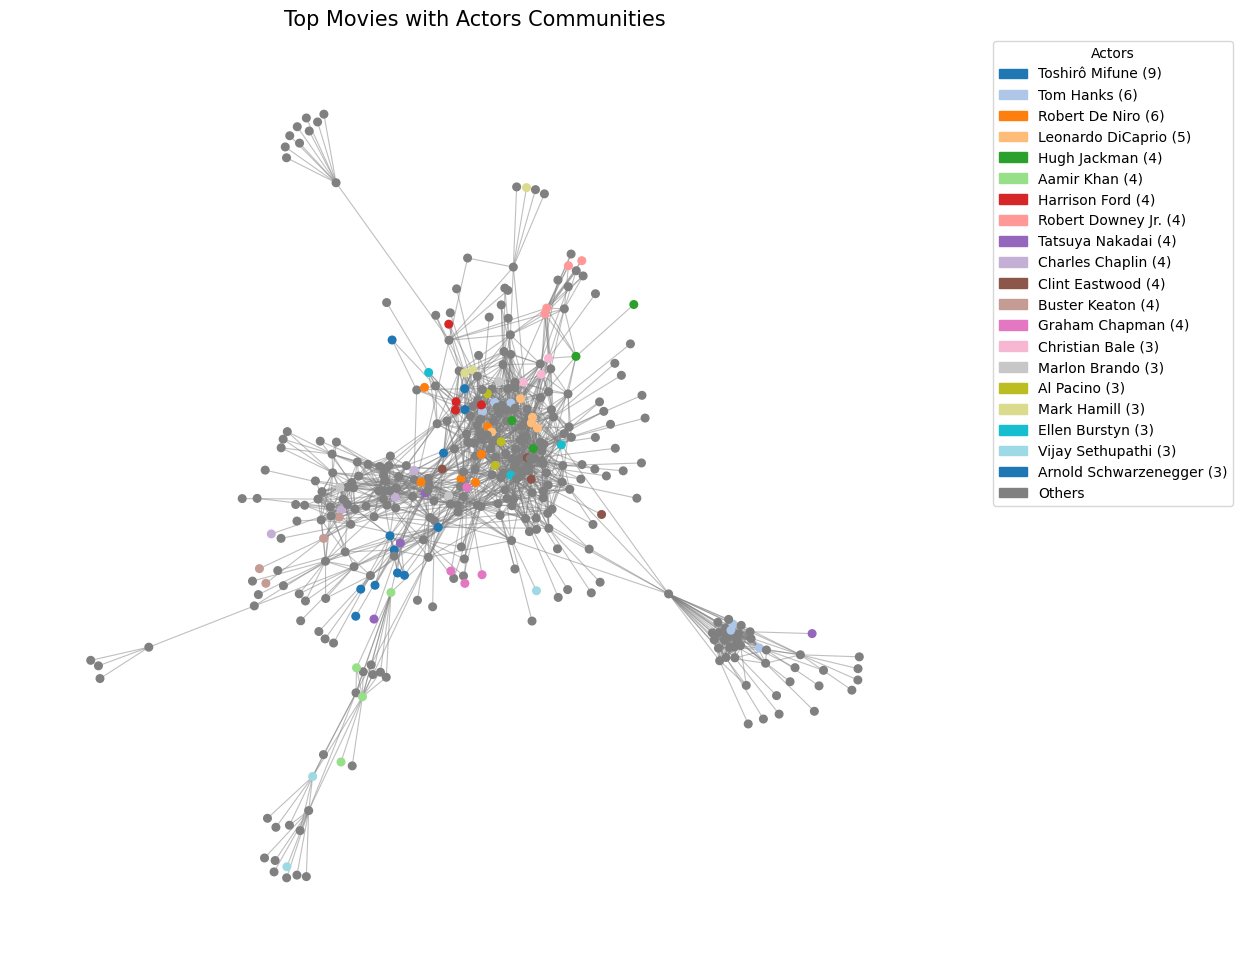

In [25]:
# Get the top 20 directors based on the number of movies (nodes), excluding 'None' or missing directors
top_20_actors = sorted(
    [(actor, nodes) for actor, nodes in actor_partition.items() if actor != "None" and actor is not None],
    key=lambda x: len(x[1]), reverse=True
)[:20]

# Create a color map for the top 20 directors, excluding the gray color from tab20
tab20_colors = list(plt.cm.tab20.colors)  # Get all 20 colors
tab20_colors.remove(plt.cm.tab20.colors[14])  # Remove the gray color (index 14 in tab20)

# Create a color map for the top 20 directors using the remaining colors
actor_to_color = {actor: tab20_colors[i % len(tab20_colors)] for i, (actor, _) in enumerate(top_20_actors)}

# Add a color for "Others" category using gray
others_color = 'gray'

# Create a list to store the color of each node based on its director
node_colors = []
for node in G.nodes:
    # Find the director of the current node by checking the partition_director dictionary
    assigned_color = others_color  # Default to "Others" for nodes without a top 20 director
    actor = None  # Initialize to None (missing director)
    
    # Check the director partition and see if the node has a director
    for dir, nodes in actor_partition.items():
        if node in nodes:
            actor = dir
            break
    
    if actor == "None" or actor is None:  # If director is "None" or missing, assign to "Others"
        assigned_color = others_color
    elif actor in actor_to_color:  # If director is in top 20, assign the corresponding color
        assigned_color = actor_to_color[actor]
    else:  # If director is not in top 20, assign to "Others"
        assigned_color = others_color

    node_colors.append(assigned_color)

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Layout for consistent positioning

# Draw the edges and nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30)

# Create a legend for the top 20 directors and "Others"
legend_handles = [
    mpatches.Patch(color=actor_to_color[actor], label=f"{actor} ({len(nodes)})")
    for actor, nodes in top_20_actors
]
legend_handles.append(mpatches.Patch(color=others_color, label="Others"))

# Add the legend
plt.legend(handles=legend_handles, title="Actors", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add title
plt.title("Top Movies with Actors Communities", fontsize=15)

# Remove axis
plt.axis('off')

# Display the plot
plt.show()


Calculate **modularity** of actor-based communities.

In [26]:
# Calculate L (total links) in the entire network
L = G.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_actor = 0
for community in actor_partition.values():
    subgraph = G.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_actor += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the actor-based partition (formula book):", modularity_actor)

Modularity of the actor-based partition (formula book): 0.05436491819868446


In [27]:
# Modularity using NetworkX
modularity_actor2 = nx.algorithms.community.modularity(G, [set(nodes) for nodes in actor_partition.values()])
print("Modularity of the actor-based partition (networkX formula):", modularity_actor2)

Modularity of the actor-based partition (networkX formula): 0.04628841288581544


#### Louvain partition
Using the Louvain method, we will detect communities within the network, each community representing a cluster of closely related nodes. 

In [28]:
# Compute the Louvain partition
louvain_partition = community_louvain.best_partition(G)

# Group nodes by their assigned community
community_groups = defaultdict(list)
for node, community in louvain_partition.items():
    community_groups[community].append(node)

print("Number of communities:", len(community_groups), "\n")
for community_id, nodes in community_groups.items():
    print(f"Community {community_id}: {len(nodes)} nodes")

Number of communities: 9 

Community 6: 65 nodes
Community 1: 31 nodes
Community 2: 30 nodes
Community 4: 25 nodes
Community 5: 78 nodes
Community 7: 43 nodes
Community 8: 30 nodes
Community 0: 44 nodes
Community 3: 45 nodes


C:\Users\nerea\AppData\Local\Temp\ipykernel_2260\1020362715.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab20', num_communities)  # Use 'tab20' for up to 20 colors


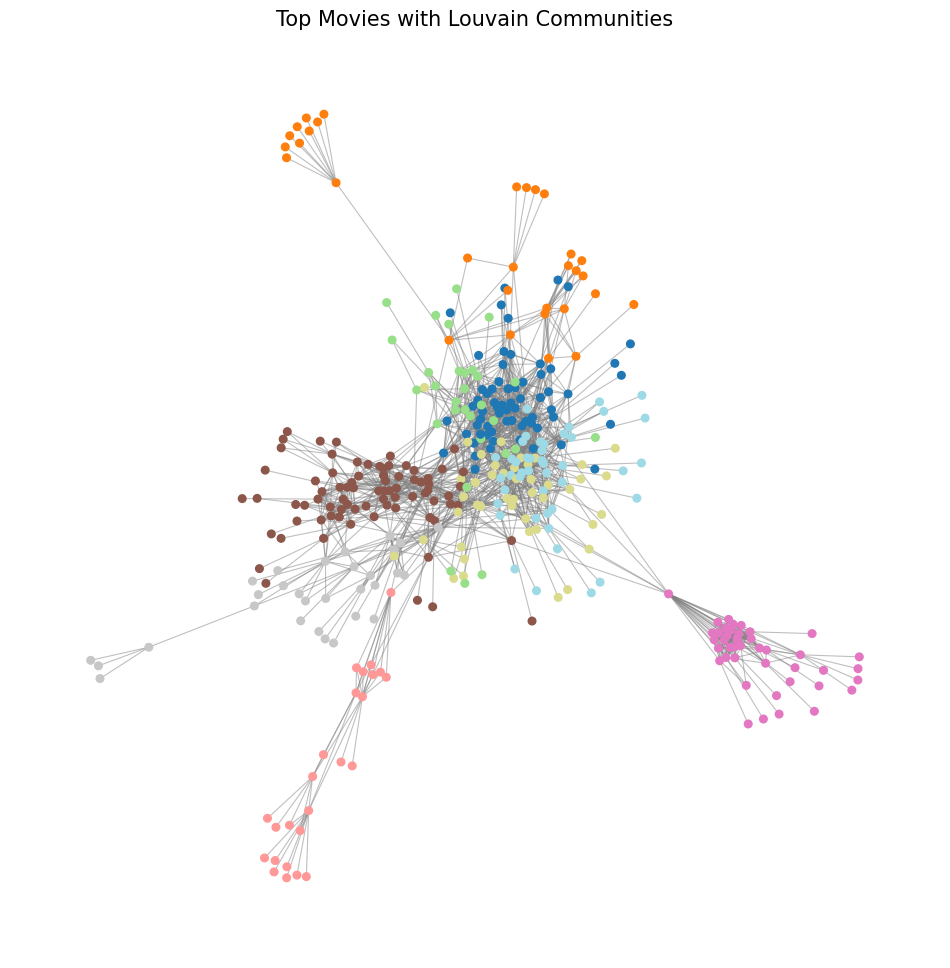

In [29]:

# Assign a unique color to each community
num_communities = len(community_groups)
color_palette = plt.cm.get_cmap('tab20', num_communities)  # Use 'tab20' for up to 20 colors
community_to_color = {community: color_palette(i) for i, community in enumerate(community_groups.keys())}

# Create a list of colors for each node based on its community
node_colors = [community_to_color[louvain_partition[node]] for node in G.nodes]

# Plot the graph with nodes colored by community
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Layout for consistent positioning

# Draw the edges and nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=0.8)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30)

# Add a title
plt.title("Top Movies with Louvain Communities", fontsize=15)

# Remove axis
plt.axis('off')

# Display the plot
plt.show()

Calculate **modularity** of Louvain communities.

In [30]:
# Calculate modularity for the Louvain partition
modularity_louvain = community_louvain.modularity(louvain_partition, G)
print("Modularity of Louvain partition:", modularity_louvain)

Modularity of Louvain partition: 0.607918772136954


The nodes in the graph are updated to store metadata fields (e.g., genres, directors, actors, etc.) as **lists instead of strings**. This allows for easier processing and analysis.

In [31]:
# Modify the nodes info to get it as list instead of string
G2 = nx.Graph(G)

# Modify the nodes to have lists of genres and directors
for node in G2.nodes:
    # Get the current node data
    data = G2.nodes[node]
    
    # Get the genres and directors as strings
    genres = data.get("Genres", "")
    directors = data.get("Director", "")
    actors = data.get("Actors", "")
    producers = data.get("Producer", "")
    production_companies = data.get("Production Companies", "")
    
    # Split the strings into lists
    genres_list = [g.strip() for g in genres.split(",")] if genres else []
    directors_list = [d.strip() for d in directors.split(",")] if directors else []
    actors_list = [a.strip() for a in actors.split(",")] if actors else []
    producers_list = [p.strip() for p in producers.split(",")] if producers else []
    production_companies_list = [pc.strip() for pc in production_companies.split(",")] if production_companies else []

    # Update the node data with the lists
    data["Genres"] = genres_list
    data["Director"] = directors_list
    data["Actors"] = actors_list
    data["Producer"] = producers_list
    data["Production Companies"] = production_companies_list

# Check the updated node data for a sample node
sample_node = "A Beautiful Mind"
if sample_node in G2.nodes:
    # Print the metadata of the node in one line each
    for key, value in G2.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: A Beautiful Mind 
Rating: 8.2 
Top 250 Rank: 150 
Duration: 135 
Release Date: 01 Mar 2002 (Denmark) 
Genres: ['Biography', 'Drama', 'Mystery']
Director: ['Ron Howard']
Actors: ['Russell Crowe', 'Ed Harris', 'Jennifer Connelly', 'Christopher Plummer', 'Paul Bettany', 'Adam Goldberg', 'Josh Lucas', 'Anthony Rapp', 'Jason Gray-Stanford', 'Judd Hirsch']
Languages: English 
Description: From the heights of notoriety to the depths of depravity, John Forbes Nash, Jr. experienced it all. A mathematical genius, he made an astonishing discovery early in his career and stood on the brink of international acclaim. But the handsome and arrogant Nash soon found himself on a painful and harrowing journey of self-discovery. After many years of struggle, he eventually triumphed over his tragedy, and finally - late in life - received the Nobel Prize. 
Plot: ['A mathematical genius, John Nash made an astonishing discovery early in his career and stood on the brink of international acclaim. But th

Checking the most common genres across all movies.

In [32]:
# check most common genres taking all into acount and not just the first
all_genres = [genre for data in G2.nodes.values() for genre in data.get("Genres", [])]
common_genres = Counter(all_genres).most_common()
print("Most common genres:")
for genre, count in common_genres:
    print(f"{genre}: {count}")

Most common genres:
Drama: 274
Action: 98
Thriller: 96
Crime: 86
Adventure: 86
Comedy: 81
Fantasy: 55
Mystery: 55
Animation: 47
Romance: 45
Sci-Fi: 45
Family: 41
Biography: 39
War: 39
History: 17
Sport: 12
Short: 11
Music: 10
Horror: 10
Documentary: 10
Musical: 8
Film-Noir: 8
Western: 6


#### Confussion matrix
Calculate confussion matrix of genre partition vs Louvain partition.

In [33]:
# Get the 10 most common genres
most_common_genres = sorted(genre_partition.keys(), key=lambda g: len(genre_partition[g]), reverse=True)[:10]

# Get 10 biggest communities
community_count = pd.Series(louvain_partition).value_counts()
most_common_communities = community_count.nlargest(10).index.tolist()

# Confusion matrix
D_matrix = np.zeros((len(most_common_genres), len(most_common_communities)), dtype=int)

for node in G2.nodes():
    # Get the genres directly from the node attributes
    node_genres = G2.nodes[node]['Genres']  # List of genres for the node
    node_community = louvain_partition[node]  # Community ID for the node
    
    # Check if the community is one of the largest ones
    if node_community in most_common_communities:
        community_index = most_common_communities.index(node_community)
        
        # Count all genres of this node
        for genre in node_genres:
            if genre in most_common_genres:
                genre_index = most_common_genres.index(genre)
                D_matrix[genre_index, community_index] += 1  # Increment the count in the matrix

# Display the confusion matrix
D_df = pd.DataFrame(D_matrix, index=most_common_genres, columns=most_common_communities)
print("Confusion Matrix (Genres vs Communities):")
print(D_df)


Confusion Matrix (Genres vs Communities):
              5   6   3   0   7   1   2   8   4
Drama        60  57  42  27  19  10   7  29  23
Action        4  19   4   9   6  25  15   4  12
Crime        14  21   7  25   2   4   0   4   9
Animation     0   0   3   2  24  18   0   0   0
Comedy       17   5  10  10  18   3   9   2   7
Biography     5   8  11   7   5   1   0   0   2
Adventure     9  12   2   2  25  16  17   1   2
Documentary   3   1   1   3   1   0   1   0   0
Short         2   1   1   3   0   1   2   1   0
Mystery      16  10   5   3   5   3   3   5   5


## TF-IDF and wordclouds for genres and communities
First, start with genres.

In [49]:
synopsis = False

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

genre_text = {}

# Iterate over nodes in the graph and extract text data
for node, data in G2.nodes(data=True):
    genres = data.get("Genres", "")

    metadata_file = os.path.join(metadata_folder, f"{node}.txt")
    
    # If the file doesn't exist, try replacing ":" and "?" with "_"
    if not os.path.exists(metadata_file):
        if node == "Car Crash: Who's Lying?":
            sanitized_node = "Car Crash_ Who's Lying_"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
        else:
            for char in [':', '?', '/']:
                sanitized_node = node.replace(char, '_')
                metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
                if os.path.exists(metadata_file):
                    break
    
    # If the file exists, parse the metadata and add it to the node
    if os.path.exists(metadata_file):
        with open(metadata_file, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            for line in lines:
                if synopsis:
                    synopsis_text = line.strip()
                    synopsis_text = re.sub(r'[^\w\s]', '', synopsis_text) # Remove punctuation
                    synopsis_text = synopsis_text.lower() # Convert to lowercase
                    synopsis_text = re.sub(r"[^a-zA-Z\s]", " ", synopsis_text)  # Remove all non-alphabetic characters
                    synopsis_text = synopsis_text.lower()  # Convert text to lowercase
                    synopsis_text = re.sub(r"\b\w{1,2}\b", "", synopsis_text)  # Remove very short words (1-2 characters)
                    synopsis_text = re.sub(r"\s+", " ", synopsis_text).strip()  # Remove extra whitespace

                    # Remove stop words and lemmatize the words
                    words = word_tokenize(synopsis_text)
                    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
                    synopsis_text = " ".join(words)

                    # Agregate text for each genre
                    for genre in genres:
                        if genre not in genre_text:
                            genre_text[genre] = ""
                        genre_text[genre] += " " + synopsis_text
                    synopsis = False
                if line.strip().startswith("Synopsis:"):
                    synopsis = True

# Print genre_texts length
print("Genre's text length:")
for genre, text in genre_text.items():
    print(f"{genre}: {len(text)}")

Genre's text length:
Drama: 1152124
Action: 511625
Crime: 400402
Thriller: 461265
Romance: 191158
Adventure: 425361
Sci-Fi: 267288
Biography: 146182
History: 51252
Fantasy: 275649
Mystery: 265446
War: 166266
Music: 23703
Comedy: 333797
Western: 26225
Short: 11
Sport: 34219
Animation: 214528
Family: 198808
Horror: 44063
Musical: 33971
Film-Noir: 47969
Documentary: 6255


In [50]:
# Tokenize the text for each genre
genre_tokens = {genre: word_tokenize(text) for genre, text in genre_text.items()}

# Count the frequency of each word in each genre
genre_word_counts = {genre: Counter(tokens) for genre, tokens in genre_tokens.items()}

In [51]:
# Generate TF list for the top 15 genres
top_genres = sorted(genre_word_counts.keys(), key=lambda x: len(genre_word_counts[x]), reverse=True)[:15]
genre_tf = {genre: {word: count for word, count in genre_word_counts[genre].items()} for genre, tokens in genre_tokens.items() if genre in top_genres}

In [52]:
# log-normalized TF for all the genres
tf_scores = {}
for genre, word_counts in genre_word_counts.items():
    tf_scores[genre] = {}
    for word, count in word_counts.items():
        tf_scores[genre][word] = 1 + math.log(count)

In [53]:
# Calculate the inverse document frequency (IDF) for each word

# Total number of genres
N = len(genre_tf)

# Initialize a Counter to store document frequencies
df_counts = Counter()

# Calculate document frequency for each word
for genre, word_list in genre_tf.items():
    df_counts.update(word_list.keys())

# Calculate IDF for each word
idf_scores = {}
for word, df in df_counts.items():
    idf_scores[word] = math.log(N/df)

In [54]:
# Calculate TF-IDF scores for each word in each genre
tfidf_scores = {}
for genre, word_list in genre_tf.items():
    tfidf_scores[genre] = {word: tf_scores[genre][word] * idf_scores[word] for word in word_list}

In [55]:
# Identify top 10 words based on TF-IDF scores
top_words_tfidf = {}
for genre, scores in tfidf_scores.items():
    # Sort words by TF-IDF score and get the top 10
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    top_words_tfidf[genre] = top_words

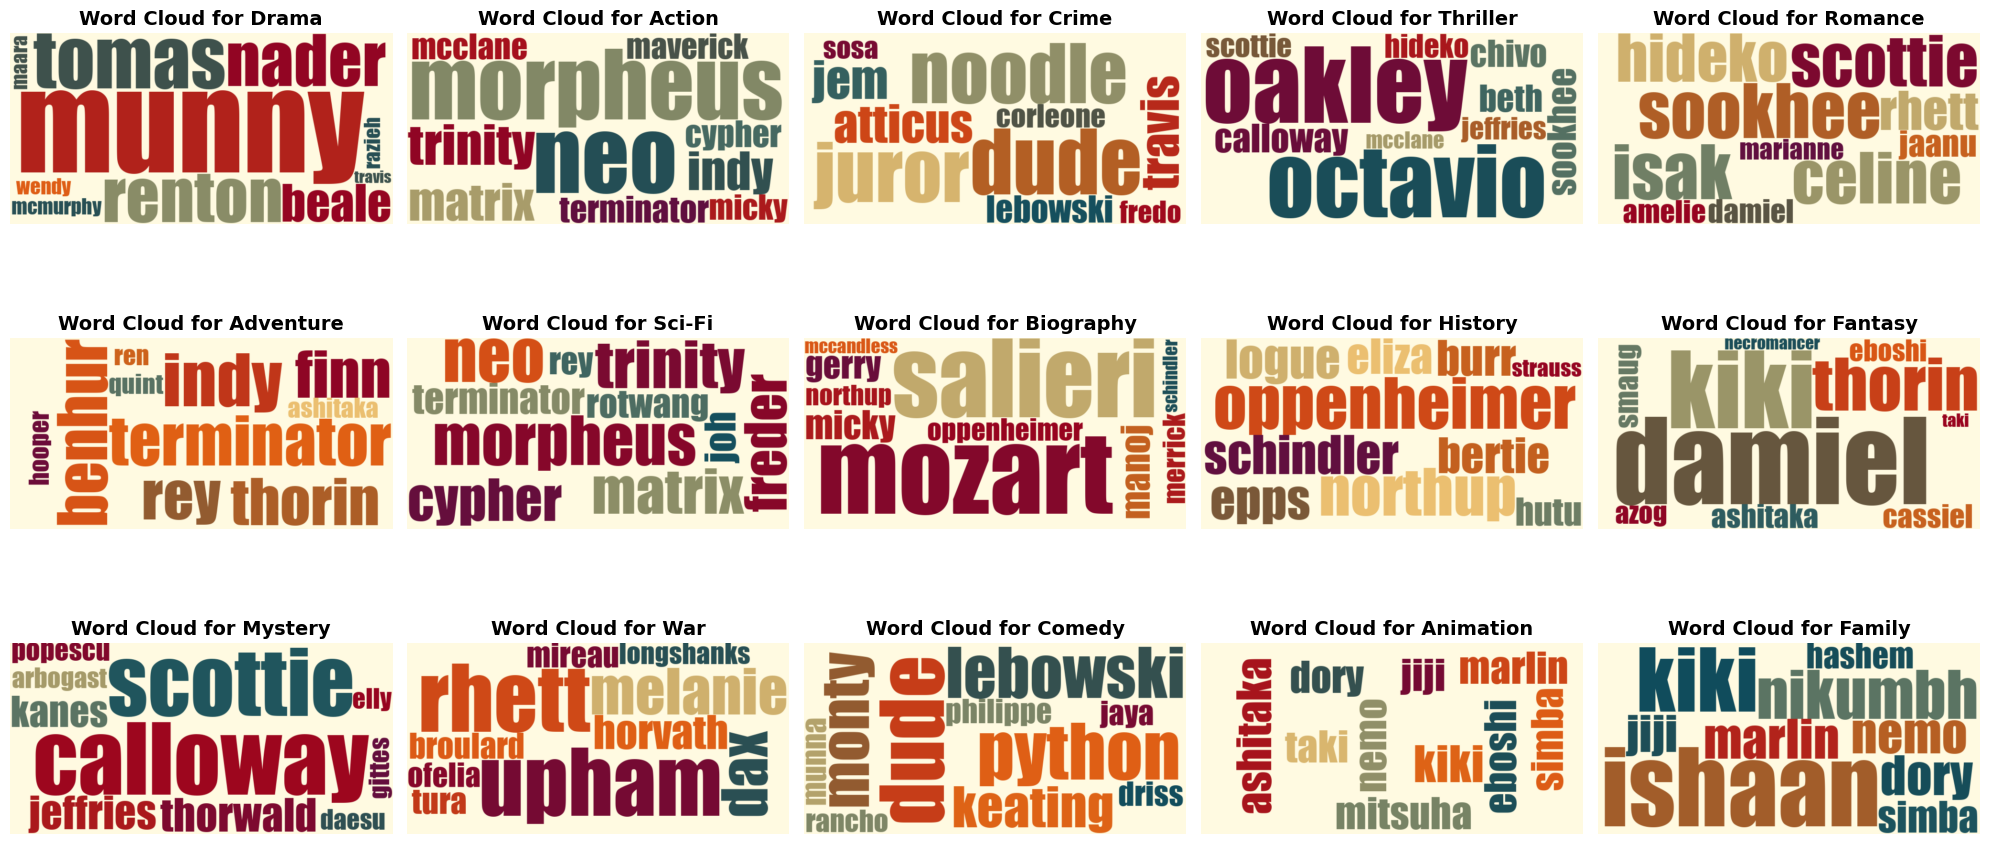

In [56]:
# Number of genres
num_genres = len(top_words_tfidf)

# Determine the number of rows and columns for the subplots
cols = 5
rows = (num_genres + cols - 1) // cols  # Proper ceiling division

# Create a figure and a set of subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Define custom colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#5F0F40", "#9A031E", "#E36414", "#0F4C5C", "#EEC170"])

# Generate word clouds
for i, (genre, top_words) in enumerate(top_words_tfidf.items()):
    # Prepare a single string with each word repeated according to its TF-IDF score
    wordcloud_input = ' '.join([word for word, score in top_words for _ in range(int(score))])
    
    # Create the word cloud with custom font, color map, and background
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='#FFFAE1',
        colormap=cmap,
        font_path='C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/impact.ttf',  # Replace with a path to a custom font (optional)
        collocations=False
    ).generate(wordcloud_input)
    
    # Display the word cloud
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(f"Word Cloud for {genre}", fontsize=14, fontweight='bold')

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Now with the Louvain communities.

In [57]:
synopsis = False

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

community_text = {}

# Iterate over nodes in the graph and extract text data
for community_id, nodes in community_groups.items():
    community_text[community_id] = ""

    for node in nodes:
        metadata_file = os.path.join(metadata_folder, f"{node}.txt")
        
        # If the file doesn't exist, try replacing ":" and "?" with "_"
        if not os.path.exists(metadata_file):
            if node == "Car Crash: Who's Lying?":
                sanitized_node = "Car Crash_ Who's Lying_"
                metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
            else:
                for char in [':', '?']:
                    sanitized_node = node.replace(char, '_')
                    metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
                    if os.path.exists(metadata_file):
                        break
        
        # If the file exists, parse the metadata and add it to the node
        if os.path.exists(metadata_file):
            with open(metadata_file, 'r', encoding='utf-8') as file:
                lines = file.readlines()
                for line in lines:
                    if synopsis:
                        synopsis_text = line.strip()
                        synopsis_text = re.sub(r'[^\w\s]', '', synopsis_text) # Remove punctuation
                        synopsis_text = synopsis_text.lower() # Convert to lowercase
                        synopsis_text = re.sub(r"[^a-zA-Z\s]", " ", synopsis_text)  # Remove all non-alphabetic characters
                        synopsis_text = synopsis_text.lower()  # Convert text to lowercase
                        synopsis_text = re.sub(r"\b\w{1,2}\b", "", synopsis_text)  # Remove very short words (1-2 characters)
                        synopsis_text = re.sub(r"\s+", " ", synopsis_text).strip()  # Remove extra whitespace

                        # Remove stop words and lemmatize the words
                        words = word_tokenize(synopsis_text)
                        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
                        synopsis_text = " ".join(words)

                        # Agregate text for each community
                        community_text[community_id] += " " + synopsis_text
                        synopsis = False
                    elif line.strip().startswith("Synopsis:"):
                        synopsis = True

print("Community's text length:")
for community, text in community_text.items():
    print(f"{community}: {len(text)}")

Community's text length:
0: 336267
1: 112657
2: 149113
3: 266304
4: 82266
5: 198810
6: 277692
7: 66469
8: 187323


In [58]:
# Tokenize the text for each community
community_tokens = {community: word_tokenize(text) for community, text in community_text.items()}
community_word_counts = {community: Counter(tokens) for community, tokens in community_tokens.items()}
community_word_counts = {community: {word: count for word, count in counts.items() if count >= 5} for community, counts in community_word_counts.items()}

In [59]:
comunity_tf = {community: {word: count for word, count in counts.items()} for community, counts in community_word_counts.items()}

In [60]:
# log-normalize Tf for all the communities
tf_scores = {}
for community, word_list in comunity_tf.items():
    tf_scores[community] = {}  # Initialize an empty dictionary for each community
    for word, count in word_list.items():
        tf_scores[community][word] = 1 + math.log(count)

In [61]:
# Calculate the inverse document frequency (IDF) for each word
N = len(comunity_tf)  # Total number of communities
df_counts = Counter()  # Initialize a Counter to store document frequencies

# Calculate document frequency for each word
for community, word_list in comunity_tf.items():
    df_counts.update(word_list.keys())

# Calculate IDF for each word
idf_scores = {}
for word, df in df_counts.items():
    idf_scores[word] = math.log(N / df)

# Calculate TF-IDF scores for each word in each community
tfidf_scores = {}
for community, word_list in comunity_tf.items():
    tfidf_scores[community] = {word: tf_scores[community][word] * idf_scores[word] for word in word_list}

# Print the TF-IDF scores for the communities
# for community, scores in tfidf_scores.items():
    # print(f"TF-IDF scores for {community}:")
    # for word, score in scores.items():
        # print(f"{word}: {score:.4f}")
    # print("\n")

In [62]:
top_words_tfidf = {}
for community, scores in tfidf_scores.items():
    # Sort words by TF-IDF score and get the top 10
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    top_words_tfidf[community] = top_words

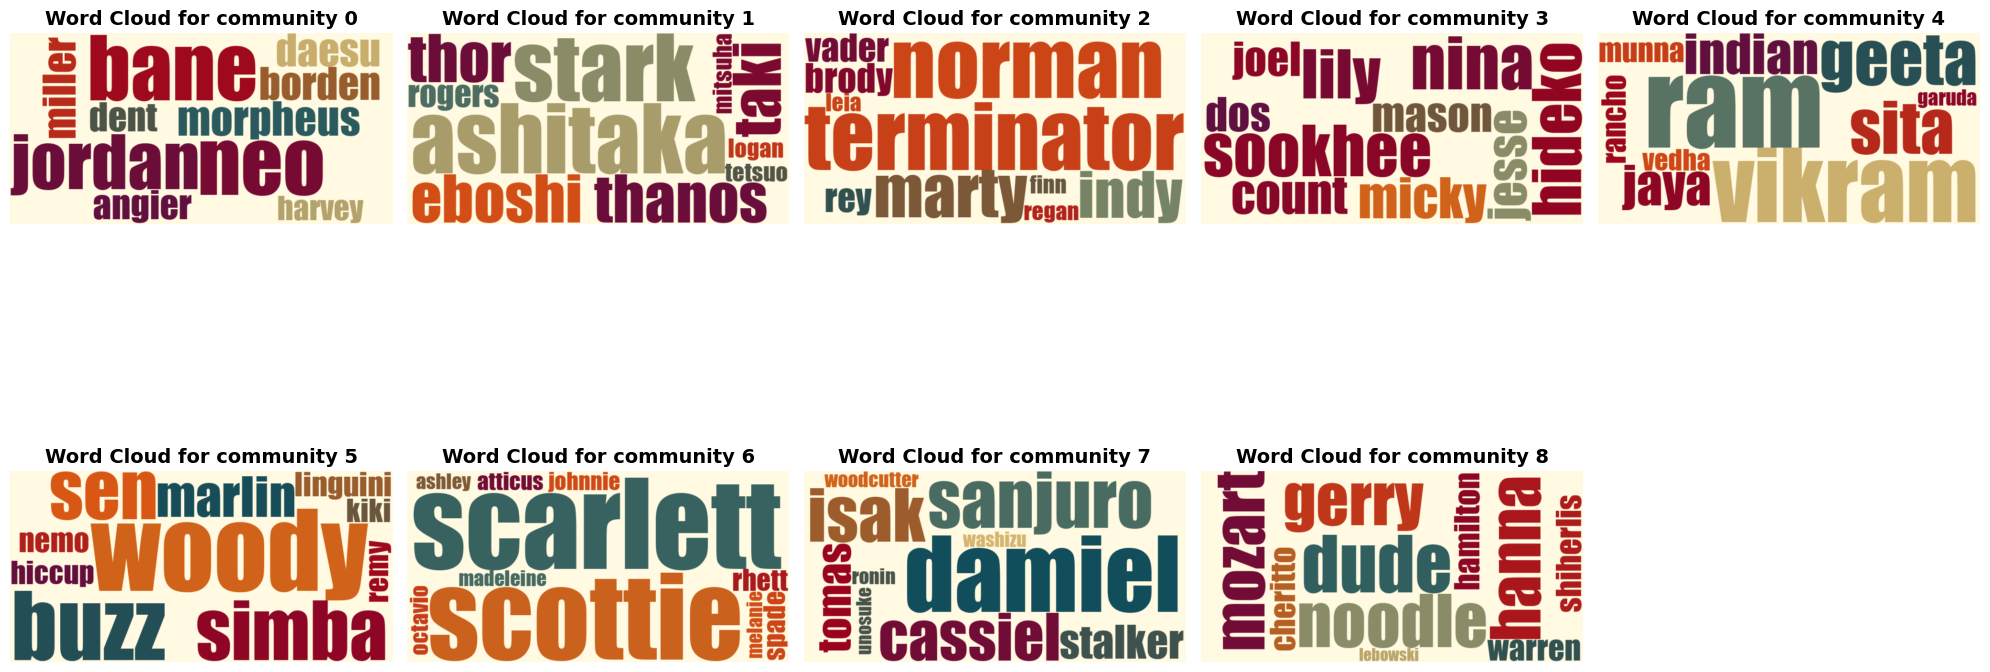

In [63]:

# Number of genres
num_communities = len(top_words_tfidf)

# Determine the number of rows and columns for the subplots
cols = 5
rows = (num_communities + cols - 1) // cols  # Proper ceiling division

# Create a figure and a set of subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Define custom colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#5F0F40", "#9A031E", "#E36414", "#0F4C5C", "#EEC170"])

# Generate word clouds
for i, (community, top_words) in enumerate(top_words_tfidf.items()):
    # Prepare a single string with each word repeated according to its TF-IDF score
    wordcloud_input = ' '.join([word for word, score in top_words for _ in range(int(score))])
    
    # Create the word cloud with custom font, color map, and background
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='#FFFAE1',
        colormap=cmap,
        font_path='C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/impact.ttf',  # Replace with a path to a custom font (optional)
        collocations=False
    ).generate(wordcloud_input)
    
    # Display the word cloud
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(f"Word Cloud for community {community}", fontsize=14, fontweight='bold')

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## BOTTOM MOVIES!
In the top movies the directed network was D and the undirected was G. 
In the bottom movies, the digraph is called K and the undirected graph is called M.

In [12]:
# Load the CSV file into a DataFrame
df = pd.read_csv('bottom_movie_data_with_similar.csv')

# Create an empty directed graph
K1 = nx.DiGraph()

# Add nodes and edges based on the similarity list
for index, row in df.iterrows():
    film = row['Name']
    similar_films = row['Similar Movies'].split(', ')  # Splitting the similar films into a list
    
    # Add the film as a node (it will be added automatically when creating edges)
    K1.add_node(film)
    
    # Add edges between the film and its similar films
    for similar_film in similar_films:
        K1.add_edge(film, similar_film)

# Delete self-loops
self_loops = list(nx.selfloop_edges(K1))
K1.remove_edges_from(self_loops)

# Num of nodes and edges
print("Number of nodes:", K1.number_of_nodes())
print("Number of edges:", K1.number_of_edges())


Number of nodes: 1762
Number of edges: 2911


Add metadata to each node as attribute.

In [13]:
# Folder containing the text files
metadata_folder = 'bottom_net_movies_info'

# Function to parse a metadata text file and exclude the "Synopsis" field
def parse_metadata(file_path):
    metadata = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        key = None
        for line in lines:
            line = line.strip()
            if line.endswith(':'):
                key = line[:-1]  # Remove the colon
                if key == 'Synopsis':  # Skip "Synopsis"
                    key = None
                else:
                    metadata[key] = ''
            elif key:  # Append the value to the current key
                metadata[key] += (' ' + line if metadata[key] else line)
    return metadata

# Add metadata to the nodes in the graph
for node in K1.nodes():
    # First, assume the filename matches the node title directly
    metadata_file = os.path.join(metadata_folder, f"{node}.txt")
    
    # If the file doesn't exist, try replacing ":", "?" and "/" with "_"
    if not os.path.exists(metadata_file):
        if node == "Naked Gun 33 1/3: The Final Insult":
            sanitized_node = "Naked Gun 33 1_3_ The Final Insult"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
        elif node == "The Room Actors: Where Are They Now?":
            sanitized_node = "The Room Actors_ Where Are They Now_"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
        elif node == "Enes Batur: Imagination or Reality?":
            sanitized_node = "Enes Batur_ Imagination or Reality_"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
        else:
            for char in [':', '?', '/']:
                sanitized_node = node.replace(char, '_')
                metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
                if os.path.exists(metadata_file):
                    break
    
    # If the file exists, parse the metadata and add it to the node
    if os.path.exists(metadata_file):
        metadata = parse_metadata(metadata_file)
        nx.set_node_attributes(K1, {node: metadata})
    else:
        print(f"Metadata file not found for {node}")

In [14]:
# Check attributes of a specific node
sample_node = "Smolensk"
if sample_node in K1.nodes:
    # Print the metadata of the node in one line each
    for key, value in K1.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: Smolensk 
Rating: 1.2 
Top 250 Rank: N/A 
Duration: 120 
Release Date: 09 Sep 2016 (Poland) 
Genres: Drama, Thriller 
Director: Antoni Krauze 
Actors: Beata Fido, Maciej Póltorak, Aldona Struzik, Lech Lotocki, Redbad Klynstra, Jerzy Zelnik, Halina Labonarska, Dominika Figurska, Maciej Góraj, Marek Probosz 
Languages: Polish, English 
Description: Inspired by true events of 2010 Polish Air Force Tu-154 mysterious crash in Smolensk, the film tells the fictional story of various people affected by the tragedy. The protagonist is a journalist Nina, who refuses to accept the official version of the story and pursues her own independent investigation. 
Plot: ["An inspired story of people affected by the 2010 crash of Polish Air Force Flight 101 in Smolensk, Russia. Fiery reporter Nina won't accept the story she's been given and is determined to find the truth.", 'Inspired by true events of 2010 Polish Air Force Tu-154 mysterious crash in Smolensk, the film tells the fictional story of

Keep only movies with a **rating lower than 5**. This will help expand the network and increase connectivity, as the bottom 250 movies start at a maximum rating of 4.8.

In [15]:
# Take only the movies with less than 5 rating for the network and remove the rest
nodes_to_remove = []

for node in K1.nodes():
    if 'Rating' in K1.nodes[node]:
        rating = K1.nodes[node]['Rating']
        if rating:
            if rating == 'N/A ':
                nodes_to_remove.append(node)
            else:
                rating = float(rating)
                if rating > 5:
                    nodes_to_remove.append(node)

K2 = K1.copy()
K2.remove_nodes_from(nodes_to_remove)
print("Number of nodes after removing:", K2.number_of_nodes())
print("Number of edges after removing:", K2.number_of_edges())

Number of nodes after removing: 640
Number of edges after removing: 1396


Keep only the largest connected component.

Number of nodes: 243
Number of edges: 912


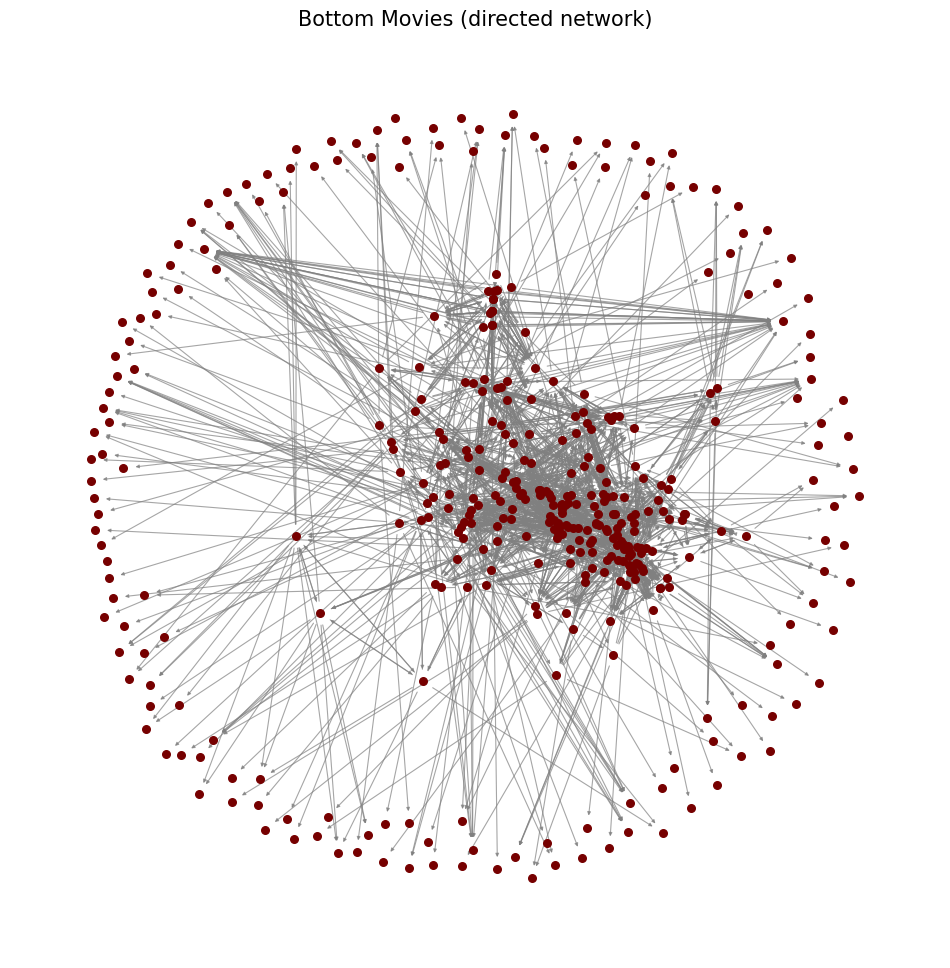

In [16]:
# Take the largest connected component
largest_cc = max(nx.weakly_connected_components(K2), key=len)
K = K2.subgraph(largest_cc)

# Num of nodes and edges
print("Number of nodes:", K.number_of_nodes())
print("Number of edges:", K.number_of_edges())

# Plot the graph
plt.figure(figsize=(12, 12))

# Positions for nodes
pos = nx.spring_layout(D2, seed=42)  # Layout for consistent

# Draw edges and nodes
nx.draw_networkx_edges(D2, pos, edge_color='gray', alpha=0.7, width=0.8, arrowsize=5)
nx.draw_networkx_nodes(D2, pos, node_color='#760000', node_size=30)

plt.title('Bottom Movies (directed network)', fontsize=15)
plt.axis('off')
plt.show()

Save all node names in a txt.

<div class="alert alert-warning">
DONT RUN AGAIN!
</div>

In [127]:
# Save node names to a text file
node_names = list(K.nodes)
with open('bottom_net_movies_titles.txt', 'w') as file:
    for node in node_names:
        file.write(f"{node}\n")

print(f"Node names have been saved.")

Node names have been saved.


### Distributions
Calculate in degree and out degree distributions.

Text(0, 0.5, 'Frequency')

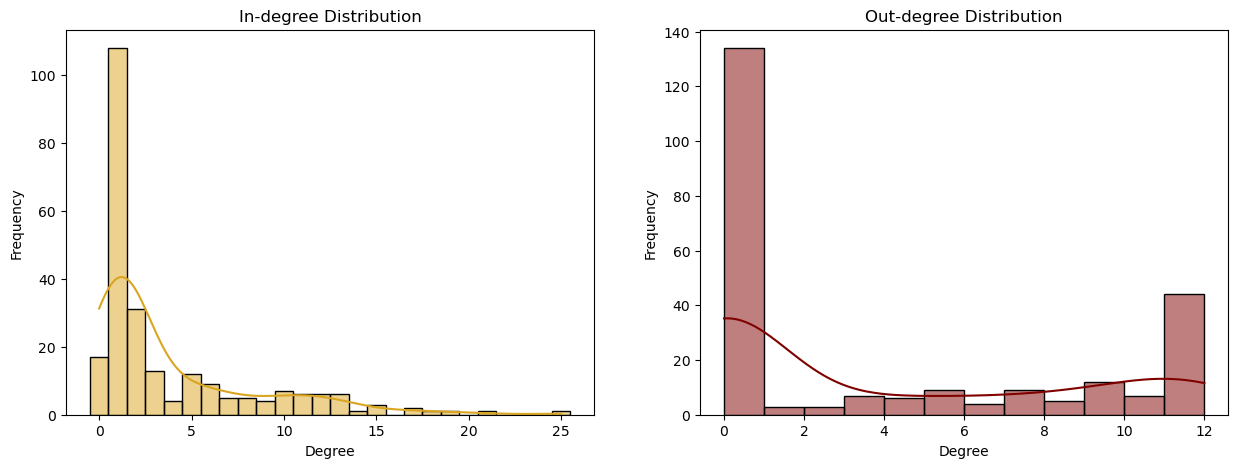

In [73]:
# Get the in-degree and out-degree for each node
in_degrees = [d for n, d in K.in_degree()]
out_degrees = [d for n, d in K.out_degree()]

# Create a pandas Series from the degree lists
in_degree_series = pd.Series(in_degrees)
out_degree_series = pd.Series(out_degrees)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define bin width and range
binwidth = 1
binrange = (min(in_degrees) - 0.5, max(in_degrees) + 0.5)

# Plot the in-degree distribution as a histogram in the first subplot
sns.histplot(in_degree_series, color='goldenrod', kde=True, ax=ax1, binwidth=binwidth, binrange=binrange)
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")

# Plot the out-degree distribution as a histogram in the second subplot
sns.histplot(out_degree_series, color='maroon', kde=True, ax=ax2, binwidth=binwidth)
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency")

Removing 134 nodes with out-degree = 0


Text(0, 0.5, 'Frequency')

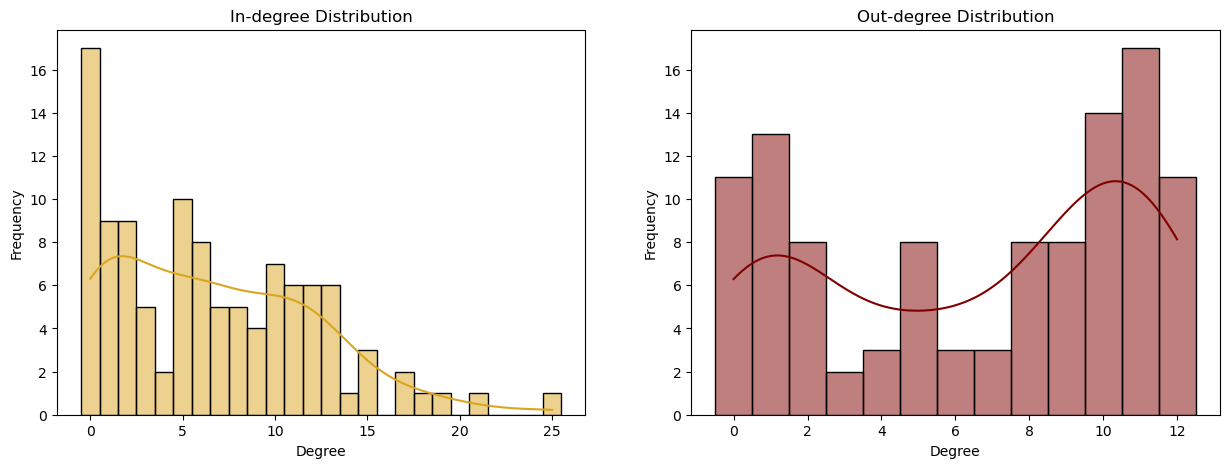

In [76]:
# Make a copy of the graph
L = K.copy()

# Remove the nodes with out-degree = 0
nodes_to_remove = [node for node, out_degree in dict(L.out_degree()).items() if out_degree == 0]
print(f"Removing {len(nodes_to_remove)} nodes with out-degree = 0")
L.remove_nodes_from(nodes_to_remove)

# Get the in-degree and out-degree for each node
in_degrees = [d for n, d in L.in_degree()]
out_degrees = [d for n, d in L.out_degree()]

# Create a pandas Series from the degree lists
in_degree_series = pd.Series(in_degrees)
out_degree_series = pd.Series(out_degrees)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define bin width and range
binwidth = 1
binrange = (min(in_degrees) - 0.5, max(in_degrees) + 0.5)

# Plot the in-degree distribution as a histogram in the first subplot
sns.histplot(in_degree_series, color='goldenrod', kde=True, ax=ax1, binwidth=binwidth, binrange=binrange)
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")

# Define bin range for out-degrees
binrange = (min(out_degrees) - 0.5, max(out_degrees) + 0.5)

# Plot the out-degree distribution as a histogram in the second subplot
sns.histplot(out_degree_series, color='maroon', kde=True, ax=ax2, binwidth=binwidth, binrange=binrange)
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency")

Print top 5 in and out-degree movies.

In [78]:
# Top 5 nodes with highest in-degree with its genre and rating
in_degrees = dict(L.in_degree())
top_5_indegree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes with highest in-degree:")
for node, indegree in top_5_indegree:
    print(f"{node} (In-degree: {indegree})")
    print(f"    Genres: {L.nodes[node].get('Genres')}")
    print(f"    Rating: {L.nodes[node].get('Rating')}")
    print(F"    Director: {L.nodes[node].get('Director')}")
    print(F"    Cast: {L.nodes[node].get('Actors')}")

Top 5 nodes with highest in-degree:
Daniel the Wizard (In-degree: 25)
    Genres: Comedy, Crime, Fantasy, Music 
    Rating: 1.2 
    Director: Ulli Lommel 
    Cast: Daniel Küblböck, Ulli Lommel, Rudolf Waldemar Brem, Katja Rupé, Günther Küblböck, Peter Schamoni, Adele Eden, Oliver Möller, Marina Lommel, Roger Fritz 
From Justin to Kelly (In-degree: 21)
    Genres: Comedy, Music, Musical, Romance 
    Rating: 1.9 
    Director: Robert Iscove 
    Cast: Kelly Clarkson, Justin Guarini, Katherine Bailess, Anika Noni Rose, Gregory Siff, Brian Dietzen, Jason Yribar, Theresa San-Nicolas, Justin Gorence, Christopher Bryan 
Pledge This! (In-degree: 19)
    Genres: Comedy 
    Rating: 1.7 
    Director: William Heins, Strathford Hamilton 
    Cast: Paris Hilton, Paula Garcés, Sarah Carter, Simon Rex, Geoffrey Arend, Alexis Thorpe, Bianca Lawson, Noureen DeWulf, Kerri Kenney, Amanda Aday 
Cosmic Sin (In-degree: 18)
    Genres: Action, Sci-Fi 
    Rating: 2.5 
    Director: Edward Drake 
    Cas

In [79]:
# Top 5 nodes with highest out-degree with its genre and rating
out_degrees = dict(L.out_degree())
top_5_outdegree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes with highest out-degree:")
for node, outdegree in top_5_outdegree:
    print(f"{node} (Out-degree: {outdegree})")
    print(f"    Genres: {L.nodes[node].get('Genres')}")
    print(f"    Rating: {L.nodes[node].get('Rating')}")
    print(F"    Director: {L.nodes[node].get('Director')}")
    print(F"    Cast: {L.nodes[node].get('Actors')}")

Top 5 nodes with highest out-degree:
From Justin to Kelly (Out-degree: 12)
    Genres: Comedy, Music, Musical, Romance 
    Rating: 1.9 
    Director: Robert Iscove 
    Cast: Kelly Clarkson, Justin Guarini, Katherine Bailess, Anika Noni Rose, Gregory Siff, Brian Dietzen, Jason Yribar, Theresa San-Nicolas, Justin Gorence, Christopher Bryan 
Cosmic Sin (Out-degree: 12)
    Genres: Action, Sci-Fi 
    Rating: 2.5 
    Director: Edward Drake 
    Cast: Frank Grillo, Bruce Willis, Brandon Thomas Lee, Corey Large, C.J. Perry Barnyashev, Perrey Reeves, Lochlyn Munro, Costas Mandylor, Eva De Dominici, Adelaide Kane 
The Human Centipede III (Final Sequence) (Out-degree: 12)
    Genres: Comedy, Horror 
    Rating: 2.7 
    Director: Tom Six 
    Cast: Dieter Laser, Laurence R. Harvey, Eric Roberts, Robert LaSardo, Tom Lister Jr., Jay Tavare, Clayton Rohner, Bree Olson, Akihiro Kitamura, Bill Hutchens 
Smolensk (Out-degree: 12)
    Genres: Drama, Thriller 
    Rating: 1.2 
    Director: Antoni K

### Communities
Make the network undirected for the following analysis.

Number of nodes: 243
Number of edges: 636


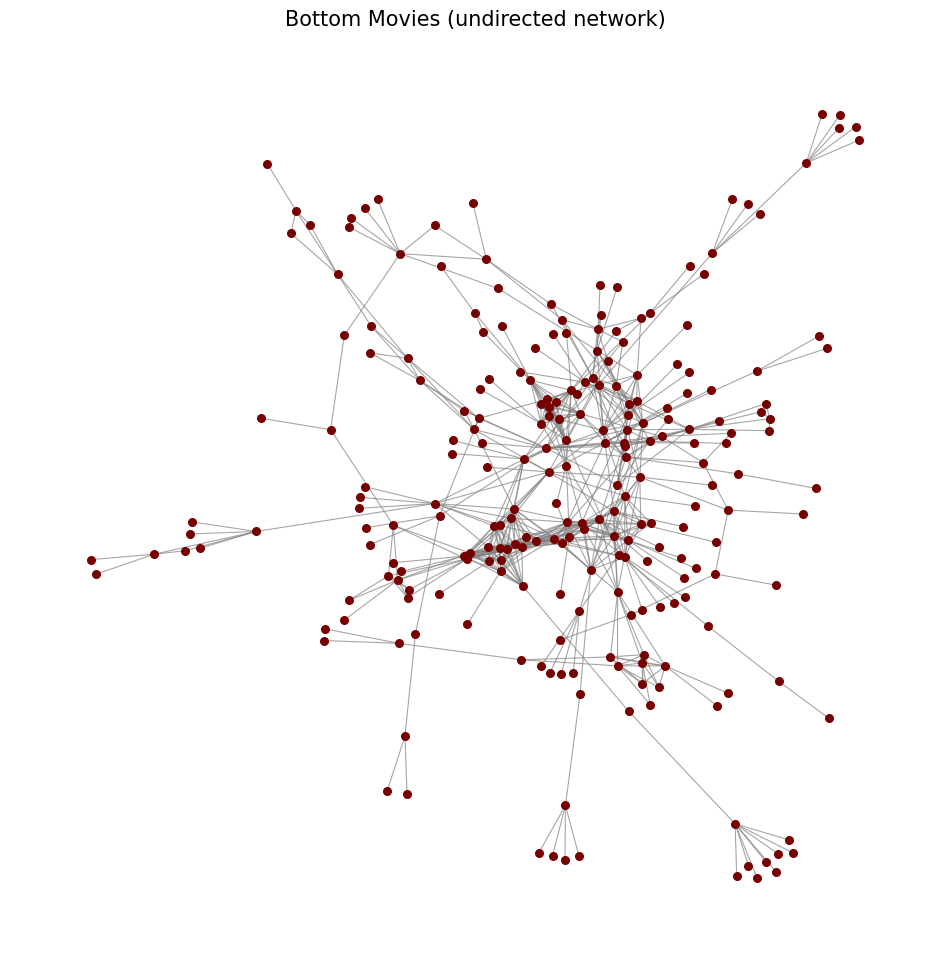

In [17]:
# Make undirected graph
M = K.to_undirected()

# Num of nodes and edges
print("Number of nodes:", M.number_of_nodes())
print("Number of edges:", M.number_of_edges())

# Plot the graph
plt.figure(figsize=(12, 12))

# Positions for nodes
pos = nx.spring_layout(M, seed=42)  # Layout for consistent

# Draw edges and nodes
nx.draw_networkx_edges(M, pos, edge_color='gray', alpha=0.7, width=0.8)
nx.draw_networkx_nodes(M, pos, node_color='#760000', node_size=30)

plt.title('Bottom Movies (undirected network)', fontsize=15)
plt.axis('off')
plt.show()

In [82]:
# Check if the undirected graph has still attributes
sample_node = "Smolensk"
if sample_node in M.nodes:
    # Print the metadata of the node in one line each
    for key, value in M.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: Smolensk 
Rating: 1.2 
Top 250 Rank: N/A 
Duration: 120 
Release Date: 09 Sep 2016 (Poland) 
Genres: Drama, Thriller 
Director: Antoni Krauze 
Actors: Beata Fido, Maciej Póltorak, Aldona Struzik, Lech Lotocki, Redbad Klynstra, Jerzy Zelnik, Halina Labonarska, Dominika Figurska, Maciej Góraj, Marek Probosz 
Languages: Polish, English 
Description: Inspired by true events of 2010 Polish Air Force Tu-154 mysterious crash in Smolensk, the film tells the fictional story of various people affected by the tragedy. The protagonist is a journalist Nina, who refuses to accept the official version of the story and pursues her own independent investigation. 
Plot: ["An inspired story of people affected by the 2010 crash of Polish Air Force Flight 101 in Smolensk, Russia. Fiery reporter Nina won't accept the story she's been given and is determined to find the truth.", 'Inspired by true events of 2010 Polish Air Force Tu-154 mysterious crash in Smolensk, the film tells the fictional story of

#### Genre partition

In [83]:
# Create a dictionary to hold the partition
genre_partition_M = {}

# Iterate over nodes in the graph and assign them to communities based on their first genre
for node, data in M.nodes(data=True):
    # Get the 'Genres' attribute and split it into a list, if present
    genres = data.get("Genres", "")  # Default to an empty string if 'Genres' is missing
    genres_list = [g.strip() for g in genres.split(",")] if genres else []  # Split and strip spaces
    
    # Get the first genre, or None if no genres are available
    first_genre = genres_list[0] if genres_list else None
    
    # Add node to the appropriate community in the partition
    if first_genre not in genre_partition_M:
        genre_partition_M[first_genre] = []
    genre_partition_M[first_genre].append(node)

print("Total number of genres:", len(genre_partition_M), "\n")
for genre, nodes in genre_partition_M.items():
    print(f"{genre}: {len(nodes)} nodes")

Total number of genres: 14 

Action: 95 nodes
Comedy: 78 nodes
Horror: 20 nodes
Documentary: 4 nodes
Family: 1 nodes
Thriller: 2 nodes
Drama: 23 nodes
Adventure: 9 nodes
Short: 2 nodes
Animation: 1 nodes
Crime: 5 nodes
Biography: 1 nodes
Mystery: 1 nodes
Sci-Fi: 1 nodes


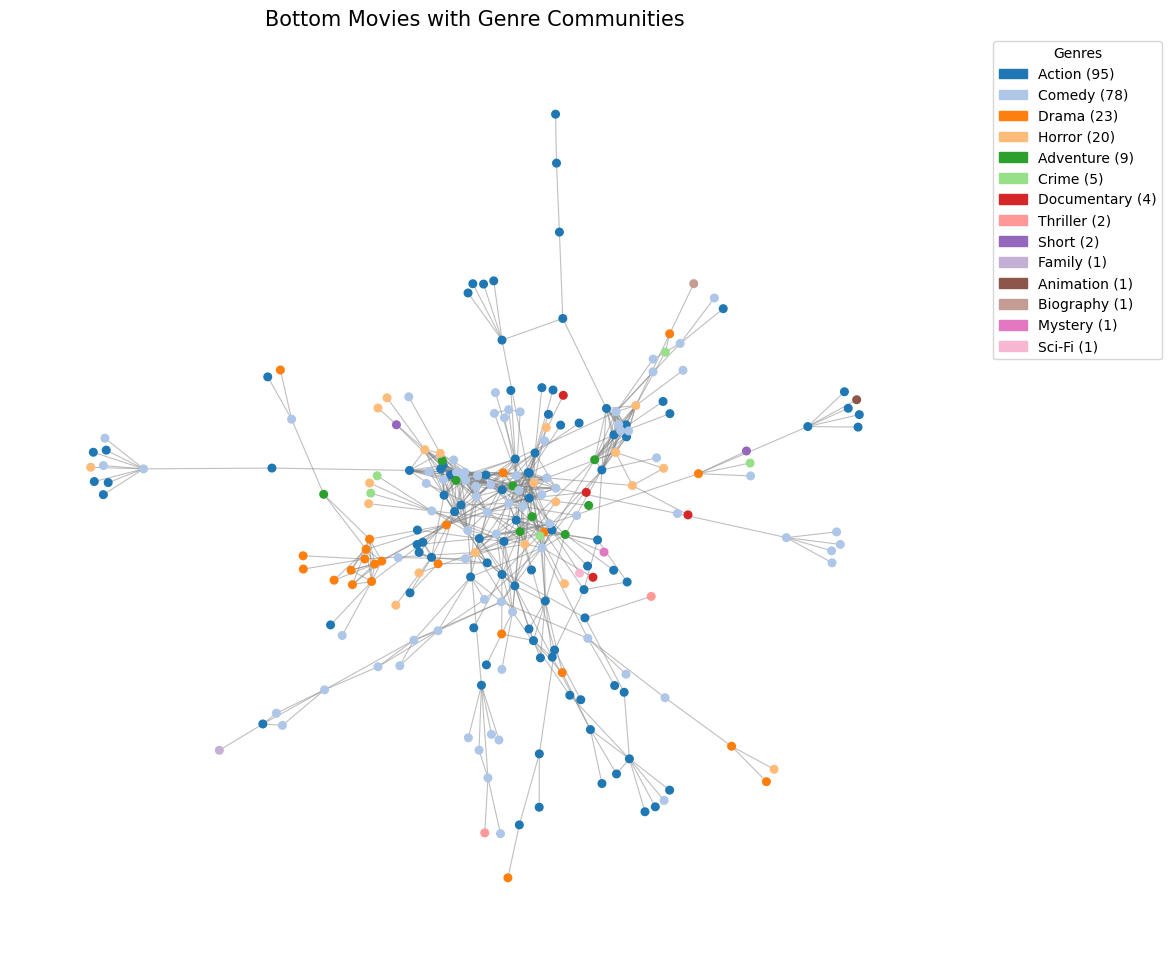

In [88]:
# Sort genres by the number of nodes, descending
sorted_genres = sorted(genre_partition_M.items(), key=lambda x: len(x[1]), reverse=True)

# Create a color map for each genre based on the sorted order
genre_to_color = {genre: plt.cm.tab20.colors[i % 20] for i, (genre, _) in enumerate(sorted_genres)}

# Create a list of colors for the nodes based on their genre
node_colors = []
for node in M.nodes:
    # Assign the corresponding color, default to "Unknown"
    assigned_color = "gray"  # Default to gray for nodes not matching any genre
    for genre, nodes in genre_partition_M.items():
        if node in nodes:
            assigned_color = genre_to_color[genre]
            break
    node_colors.append(assigned_color)

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(M, seed=42)  # Layout for consistent positioning

nx.draw_networkx_edges(M, pos, edge_color="gray", alpha=0.5, width=0.8)
nx.draw_networkx_nodes(M, pos, node_color=node_colors, node_size=30)

# Create a sorted legend
legend_handles = [
    mpatches.Patch(color=genre_to_color[genre], label=f"{genre} ({len(nodes)})")
    for genre, nodes in sorted_genres
]
plt.legend(handles=legend_handles, title="Genres", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Bottom Movies with Genre Communities", fontsize=15)
plt.axis("off")
plt.show()


Calculate the **modularity** of the genre-based partition.

In [85]:
# Calculate L (total links) in the entire network
L = M.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_genre = 0
for community in genre_partition_M.values():
    subgraph = M.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_genre += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the genre-based partition (formula book):", modularity_genre)

Modularity of the genre-based partition (formula book): 0.3628836873541394


In [86]:
# Modularity using NetworkX
modularity_genre2 = nx.algorithms.community.modularity(M, [set(nodes) for nodes in genre_partition_M.values()])
print("Modularity of the genre-based partition (networkX formula):", modularity_genre2)

Modularity of the genre-based partition (networkX formula): 0.13305199556979547


#### Director partition

In [87]:
# Create a dictionary to hold the partition
director_partition_M = {}

# Iterate over nodes in the graph and assign them to communities based on their first genre
for node, data in M.nodes(data=True):
    # Get the 'Directors' attribute and split it into a list, if present
    directors = data.get("Director", "")  # Default to an empty string if 'Genres' is missing
    directors_list = [g.strip() for g in directors.split(",")] if directors else []  # Split and strip spaces
    
    # Get the first genre, or None if no genres are available
    first_director = directors_list[0] if directors_list else None
    
    # Add node to the appropriate community in the partition
    if first_director not in director_partition_M:
        director_partition_M[first_director] = []
    director_partition_M[first_director].append(node)

print("Total number of directors:", len(director_partition_M), "\n")
for director, nodes in director_partition_M.items():
    print(f"{director}: {len(nodes)} nodes")

Total number of directors: 184 

Roger Christian: 1 nodes
Prabhu Deva: 3 nodes
Michael Tiddes: 4 nodes
Robert Iscove: 1 nodes
Nick Cannon: 1 nodes
Stephen Herek: 1 nodes
Arbaaz Khan: 1 nodes
M Jenithkumar: 1 nodes
Gabor Csupo: 1 nodes
Charles Robert Carner: 1 nodes
None: 4 nodes
Matt Eskandari: 1 nodes
Pitof: 1 nodes
Ahmed Khan: 3 nodes
Sajid: 2 nodes
Bob Logan: 1 nodes
Alan Metter: 1 nodes
Ali Abbas Zafar: 2 nodes
Alex Nicolaou: 1 nodes
John Luessenhop: 1 nodes
Jason Friedberg: 7 nodes
John Carl Buechler: 2 nodes
James Keach: 1 nodes
Kurt Wimmer: 1 nodes
David Dhawan: 2 nodes
Bill Corcoran: 2 nodes
Jan de Bont: 1 nodes
James Wong: 2 nodes
C.B. Harding: 3 nodes
Uwe Boll: 10 nodes
Bert I. Gordon: 1 nodes
Jim Wynorski: 3 nodes
Amin Hajee: 1 nodes
Sohail Khan: 1 nodes
Sylvain White: 2 nodes
Albert Band: 1 nodes
Hyung-rae Shim: 1 nodes
Álvaro de Armiñán: 1 nodes
Richard Lester: 1 nodes
Remo D'Souza: 3 nodes
Craig R. Baxley: 1 nodes
Jeff Burr: 1 nodes
Franco Zeffirelli: 1 nodes
Michael Hurs

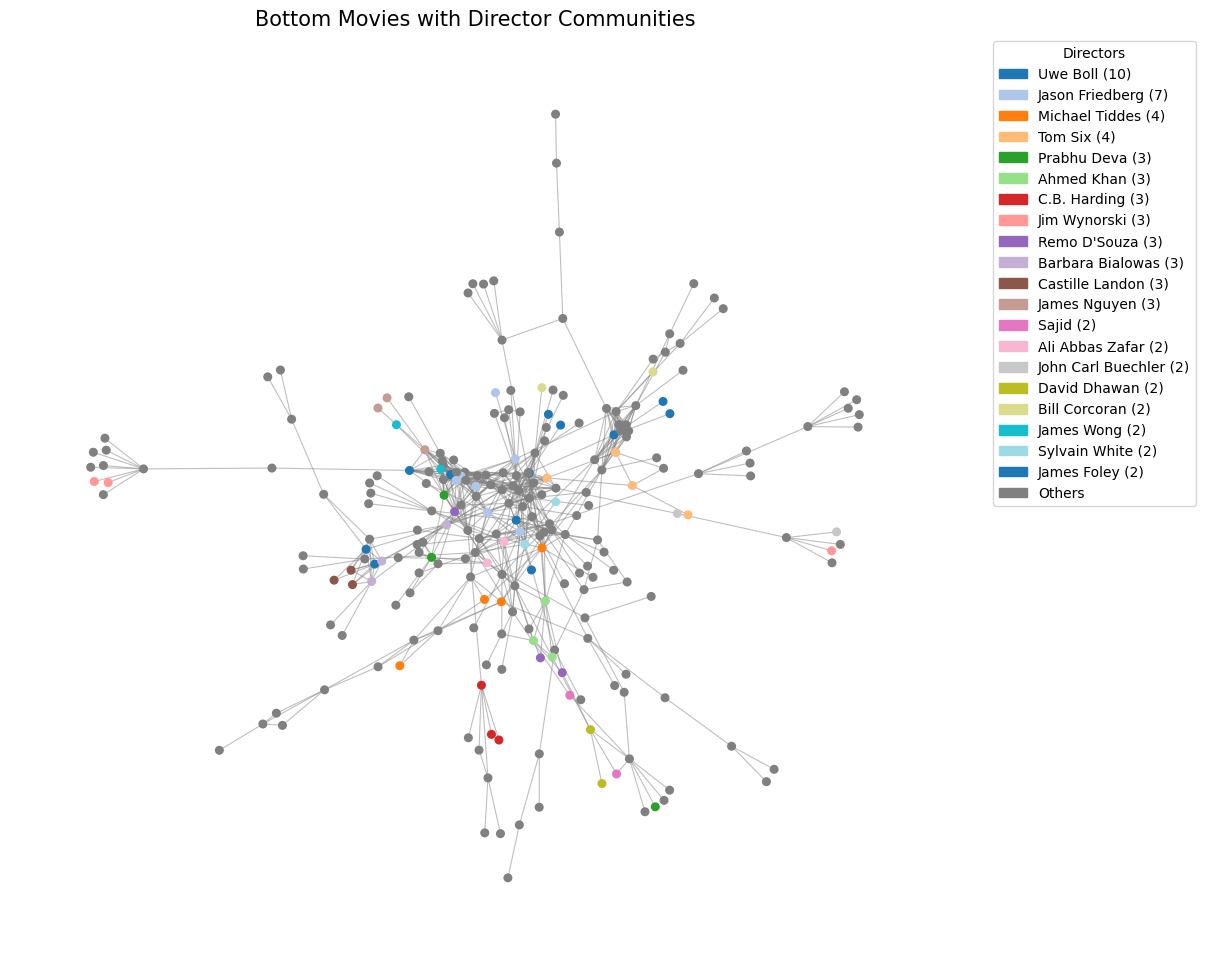

In [89]:
# Get the top 20 directors based on the number of movies (nodes), excluding 'None' or missing directors
top_20_directors = sorted(
    [(director, nodes) for director, nodes in director_partition_M.items() if director != "None" and director is not None],
    key=lambda x: len(x[1]), reverse=True
)[:20]

# Create a color map for the top 20 directors, excluding the gray color from tab20
tab20_colors = list(plt.cm.tab20.colors)  # Get all 20 colors
tab20_colors.remove(plt.cm.tab20.colors[14])  # Remove the gray color (index 14 in tab20)

# Create a color map for the top 20 directors using the remaining colors
director_to_color = {director: tab20_colors[i % len(tab20_colors)] for i, (director, _) in enumerate(top_20_directors)}

# Add a color for "Others" category using gray
others_color = 'gray'

# Create a list to store the color of each node based on its director
node_colors = []
for node in M.nodes:
    # Find the director of the current node by checking the partition_director dictionary
    assigned_color = others_color  # Default to "Others" for nodes without a top 20 director
    director = None  # Initialize to None (missing director)
    
    # Check the director partition and see if the node has a director
    for dir, nodes in director_partition_M.items():
        if node in nodes:
            director = dir
            break
    
    if director == "None" or director is None:  # If director is "None" or missing, assign to "Others"
        assigned_color = others_color
    elif director in director_to_color:  # If director is in top 20, assign the corresponding color
        assigned_color = director_to_color[director]
    else:  # If director is not in top 20, assign to "Others"
        assigned_color = others_color

    node_colors.append(assigned_color)

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(M, seed=42)  # Layout for consistent positioning

# Draw the edges and nodes
nx.draw_networkx_edges(M, pos, edge_color='gray', alpha=0.5, width=0.8)
nx.draw_networkx_nodes(M, pos, node_color=node_colors, node_size=30)

# Create a legend for the top 20 directors and "Others"
legend_handles = [
    mpatches.Patch(color=director_to_color[director], label=f"{director} ({len(nodes)})")
    for director, nodes in top_20_directors
]
legend_handles.append(mpatches.Patch(color=others_color, label="Others"))

# Add the legend
plt.legend(handles=legend_handles, title="Directors", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a title
plt.title("Bottom Movies with Director Communities", fontsize=15)

# Remove axis
plt.axis('off')

# Display the plot
plt.show()


Calculate **modularity** of the director based communities.

In [90]:
# Calculate L (total links) in the entire network
L = M.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_director = 0
for community in director_partition_M.values():
    subgraph = M.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_director += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the director-based partition (formula book):", modularity_director)

Modularity of the director-based partition (formula book): 0.07161504687314584


In [91]:
# Modularity using NetworkX
modularity_director2 = nx.algorithms.community.modularity(M, [set(nodes) for nodes in director_partition_M.values()])
print("Modularity of the director-based partition (networkX formula):", modularity_director2)

Modularity of the director-based partition (networkX formula): 0.0553417091887188


#### Actor communities

In [94]:
# Create a dictionary to hold the partition
actor_partition_M = {}

# Iterate over nodes in the graph and assign them to communities based on their first actor
for node, data in M.nodes(data=True):
    # Get the 'Actors' attribute and split it into a list, if present
    actors = data.get("Actors", "")  # Default to an empty string if 'Actors' is missing
    actors_list = [g.strip() for g in actors.split(",")] if actors else []  # Split and strip spaces
    
    # Get the first actor, or None if no actors are available
    first_actor = actors_list[0] if actors_list else None
    
    # Add node to the appropriate community in the partition
    if first_actor not in actor_partition_M:
        actor_partition_M[first_actor] = []
    actor_partition_M[first_actor].append(node)

# Output the partition information
print("Total number of actors:", len(actor_partition_M), "\n")
for actor, nodes in actor_partition_M.items():
    print(f"{actor}: {len(nodes)} nodes")

Total number of actors: 179 

John Travolta: 1 nodes
Salman Khan: 7 nodes
Marlon Wayans: 5 nodes
Kelly Clarkson: 1 nodes
Patrick Warburton: 1 nodes
Eddie Murphy: 5 nodes
Yaashika Aanand: 1 nodes
Tamás Szabó Kimmel: 1 nodes
Larry the Cable Guy: 2 nodes
Matt Borlenghi: 1 nodes
Bruce Willis: 2 nodes
Halle Berry: 1 nodes
Boris Grey: 1 nodes
Akshay Kumar: 10 nodes
Linda Blair: 1 nodes
George Gaynes: 1 nodes
Ranveer Singh: 1 nodes
Circus-Szalewski: 1 nodes
Alexandra Daddario: 1 nodes
Desiree Hall: 1 nodes
Evan MacKenzie: 1 nodes
Leslie Nielsen: 2 nodes
Milla Jovovich: 1 nodes
Varun Dhawan: 3 nodes
Patrick Cavanaugh: 1 nodes
Sandra Bullock: 1 nodes
Justin Chatwin: 2 nodes
Jim Breuer: 1 nodes
Christian Slater: 1 nodes
Janaya Stephens: 1 nodes
Ed Kemmer: 1 nodes
David Carradine: 1 nodes
Kunal Kapoor: 1 nodes
Joey King: 2 nodes
Damon Martin: 1 nodes
Jason Behr: 1 nodes
Mike Vogel: 1 nodes
Christopher Reeve: 2 nodes
Louis Gossett Jr.: 1 nodes
Kate Hodge: 1 nodes
Brooke Shields: 2 nodes
Emmanuelle

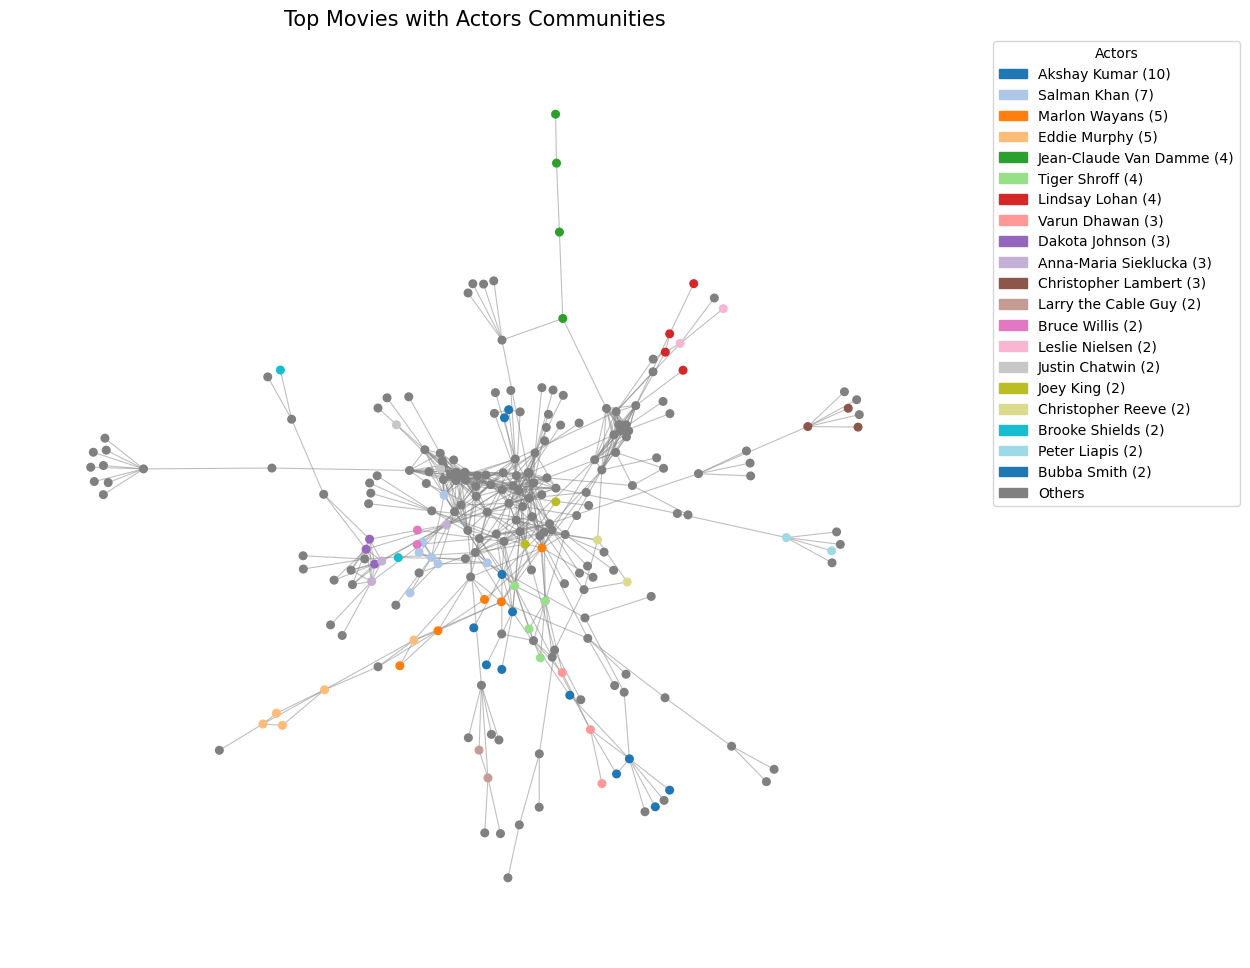

In [95]:
# Get the top 20 directors based on the number of movies (nodes), excluding 'None' or missing directors
top_20_actors = sorted(
    [(actor, nodes) for actor, nodes in actor_partition_M.items() if actor != "None" and actor is not None],
    key=lambda x: len(x[1]), reverse=True
)[:20]

# Create a color map for the top 20 directors, excluding the gray color from tab20
tab20_colors = list(plt.cm.tab20.colors)  # Get all 20 colors
tab20_colors.remove(plt.cm.tab20.colors[14])  # Remove the gray color (index 14 in tab20)

# Create a color map for the top 20 directors using the remaining colors
actor_to_color = {actor: tab20_colors[i % len(tab20_colors)] for i, (actor, _) in enumerate(top_20_actors)}

# Add a color for "Others" category using gray
others_color = 'gray'

# Create a list to store the color of each node based on its director
node_colors = []
for node in M.nodes:
    # Find the director of the current node by checking the partition_director dictionary
    assigned_color = others_color  # Default to "Others" for nodes without a top 20 director
    actor = None  # Initialize to None (missing director)
    
    # Check the director partition and see if the node has a director
    for dir, nodes in actor_partition_M.items():
        if node in nodes:
            actor = dir
            break
    
    if actor == "None" or actor is None:  # If director is "None" or missing, assign to "Others"
        assigned_color = others_color
    elif actor in actor_to_color:  # If director is in top 20, assign the corresponding color
        assigned_color = actor_to_color[actor]
    else:  # If director is not in top 20, assign to "Others"
        assigned_color = others_color

    node_colors.append(assigned_color)

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(M, seed=42)  # Layout for consistent positioning

# Draw the edges and nodes
nx.draw_networkx_edges(M, pos, edge_color='gray', alpha=0.5, width=0.8)
nx.draw_networkx_nodes(M, pos, node_color=node_colors, node_size=30)

# Create a legend for the top 20 directors and "Others"
legend_handles = [
    mpatches.Patch(color=actor_to_color[actor], label=f"{actor} ({len(nodes)})")
    for actor, nodes in top_20_actors
]
legend_handles.append(mpatches.Patch(color=others_color, label="Others"))

# Add the legend
plt.legend(handles=legend_handles, title="Actors", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add title
plt.title("Top Movies with Actors Communities", fontsize=15)

# Remove axis
plt.axis('off')

# Display the plot
plt.show()


Calculate **modularity** of the actors based communities.

In [96]:
# Calculate L (total links) in the entire network
L = M.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_actor = 0
for community in actor_partition_M.values():
    subgraph = M.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_actor += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the actor-based partition (formula book):", modularity_actor)

Modularity of the actor-based partition (formula book): 0.09823830149123845


In [97]:
# Modularity using NetworkX
modularity_actor2 = nx.algorithms.community.modularity(M, [set(nodes) for nodes in actor_partition_M.values()])
print("Modularity of the actor-based partition (networkX formula):", modularity_actor2)

Modularity of the actor-based partition (networkX formula): 0.0869934436928919


#### Louvain partition

In [98]:
# Compute the Louvain partition
louvain_partition_M = community_louvain.best_partition(M)

# Group nodes by their assigned community
community_groups = defaultdict(list)
for node, community in louvain_partition_M.items():
    community_groups[community].append(node)

print("Number of communities:", len(community_groups), "\n")
for community_id, nodes in community_groups.items():
    print(f"Community {community_id}: {len(nodes)} nodes")

Number of communities: 14 

Community 0: 32 nodes
Community 1: 19 nodes
Community 3: 19 nodes
Community 4: 15 nodes
Community 5: 8 nodes
Community 6: 25 nodes
Community 7: 30 nodes
Community 8: 6 nodes
Community 9: 27 nodes
Community 10: 10 nodes
Community 11: 6 nodes
Community 12: 27 nodes
Community 13: 10 nodes
Community 2: 9 nodes


C:\Users\Alba\AppData\Local\Temp\ipykernel_15160\3337303700.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab20', num_communities)  # Use 'tab20' for up to 20 colors


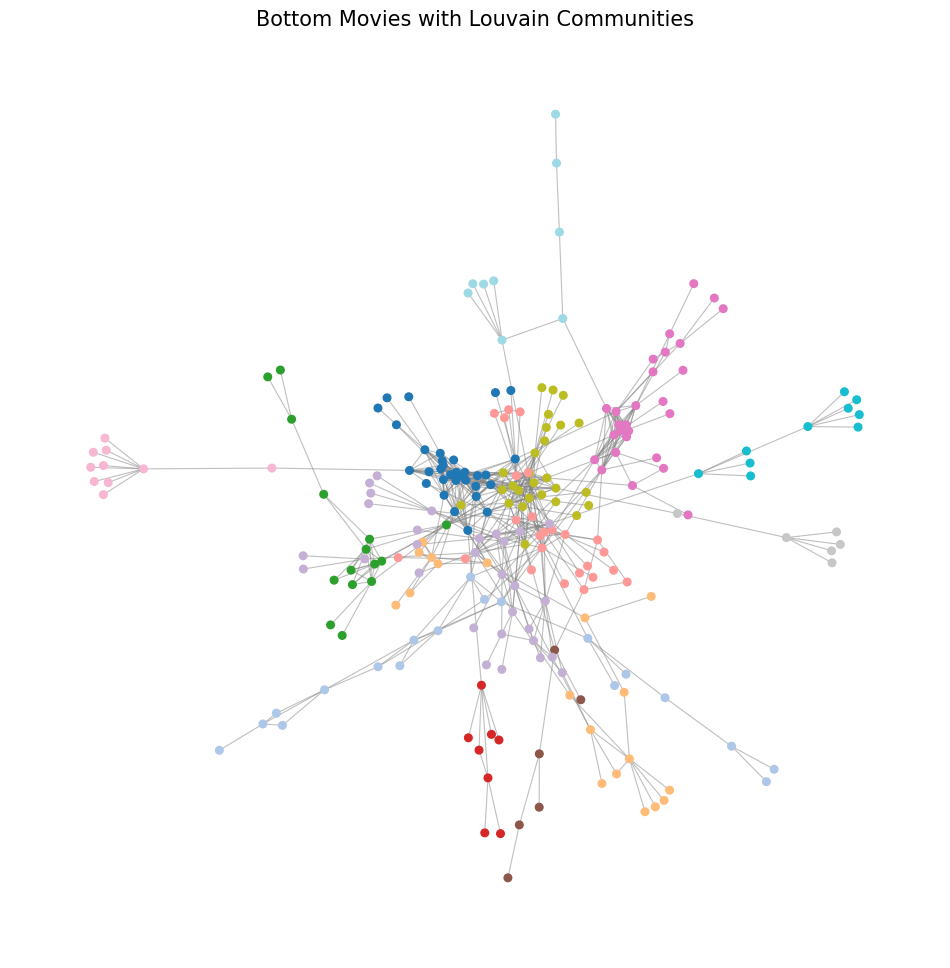

In [99]:
# Assign a unique color to each community
num_communities = len(community_groups)
color_palette = plt.cm.get_cmap('tab20', num_communities)  # Use 'tab20' for up to 20 colors
community_to_color = {community: color_palette(i) for i, community in enumerate(community_groups.keys())}

# Create a list of colors for each node based on its community
node_colors = [community_to_color[louvain_partition_M[node]] for node in M.nodes]

# Plot the graph with nodes colored by community
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(M, seed=42)  # Layout for consistent positioning

# Draw the edges and nodes
nx.draw_networkx_edges(M, pos, edge_color='gray', alpha=0.5, width=0.8)
nx.draw_networkx_nodes(M, pos, node_color=node_colors, node_size=30)

# Add a title
plt.title("Bottom Movies with Louvain Communities", fontsize=15)

# Remove axis
plt.axis('off')

# Display the plot
plt.show()

Calculate modularity of the director based communities.

In [100]:
# Calculate modularity for the Louvain partition
modularity_louvain = community_louvain.modularity(louvain_partition_M, M)
print("Modularity of Louvain partition:", modularity_louvain)

Modularity of Louvain partition: 0.696815296072149


The nodes in the graph are updated to store metadata fields (e.g., genres, directors, actors, etc.) as **lists instead of strings**. This allows for easier processing and analysis.

In [18]:
# Modify the nodes info to get it as list instead of string
M2 = nx.Graph(M)

# Modify the nodes to have lists of genres and directors
for node in M2.nodes:
    # Get the current node data
    data = M2.nodes[node]
    
    # Get the genres and directors as strings
    genres = data.get("Genres", "")
    directors = data.get("Director", "")
    actors = data.get("Actors", "")
    producers = data.get("Producer", "")
    production_companies = data.get("Production Companies", "")
    
    # Split the strings into lists
    genres_list = [g.strip() for g in genres.split(",")] if genres else []
    directors_list = [d.strip() for d in directors.split(",")] if directors else []
    actors_list = [a.strip() for a in actors.split(",")] if actors else []
    producers_list = [p.strip() for p in producers.split(",")] if producers else []
    production_companies_list = [pc.strip() for pc in production_companies.split(",")] if production_companies else []

    # Update the node data with the lists
    data["Genres"] = genres_list
    data["Director"] = directors_list
    data["Actors"] = actors_list
    data["Producer"] = producers_list
    data["Production Companies"] = production_companies_list

# Check the updated node data for a sample node
sample_node = "Smolensk"
if sample_node in M2.nodes:
    # Print the metadata of the node in one line each
    for key, value in M2.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: Smolensk 
Rating: 1.2 
Top 250 Rank: N/A 
Duration: 120 
Release Date: 09 Sep 2016 (Poland) 
Genres: ['Drama', 'Thriller']
Director: ['Antoni Krauze']
Actors: ['Beata Fido', 'Maciej Póltorak', 'Aldona Struzik', 'Lech Lotocki', 'Redbad Klynstra', 'Jerzy Zelnik', 'Halina Labonarska', 'Dominika Figurska', 'Maciej Góraj', 'Marek Probosz']
Languages: Polish, English 
Description: Inspired by true events of 2010 Polish Air Force Tu-154 mysterious crash in Smolensk, the film tells the fictional story of various people affected by the tragedy. The protagonist is a journalist Nina, who refuses to accept the official version of the story and pursues her own independent investigation. 
Plot: ["An inspired story of people affected by the 2010 crash of Polish Air Force Flight 101 in Smolensk, Russia. Fiery reporter Nina won't accept the story she's been given and is determined to find the truth.", 'Inspired by true events of 2010 Polish Air Force Tu-154 mysterious crash in Smolensk, the film

Get the msot common genres across all BOTTOM movies.

In [19]:
# check most common genres taking all into acount and not just the first
all_genres = [genre for data in M2.nodes.values() for genre in data.get("Genres", [])]
common_genres = Counter(all_genres).most_common()
print("Most common genres:")
for genre, count in common_genres:
    print(f"{genre}: {count}")

Most common genres:
Comedy: 125
Action: 97
Thriller: 77
Horror: 74
Drama: 60
Sci-Fi: 55
Romance: 46
Fantasy: 43
Adventure: 42
Crime: 35
Mystery: 16
Music: 10
Sport: 7
Documentary: 4
Short: 3
History: 3
War: 3
Musical: 3
Western: 2
Biography: 2
Animation: 1
Family: 1


### Confussion matrix
Calculate confussion matrix of genre partition vs Louvain partition.

In [104]:
# Get the 10 most common genres
most_common_genres = sorted(genre_partition_M.keys(), key=lambda g: len(genre_partition_M[g]), reverse=True)[:10]

# Get 10 biggest communities
community_count = pd.Series(louvain_partition_M).value_counts()
most_common_communities = community_count.nlargest(10).index.tolist()

# Confusion matrix
D_matrix_M = np.zeros((len(most_common_genres), len(most_common_communities)), dtype=int)

for node in M2.nodes():
    # Get the genres directly from the node attributes
    node_genres = M2.nodes[node]['Genres']  # List of genres for the node
    node_community = louvain_partition_M[node]  # Community ID for the node
    
    # Check if the community is one of the largest ones
    if node_community in most_common_communities:
        community_index = most_common_communities.index(node_community)
        
        # Count all genres of this node
        for genre in node_genres:
            if genre in most_common_genres:
                genre_index = most_common_genres.index(genre)
                D_matrix_M[genre_index, community_index] += 1  # Increment the count in the matrix

# Display the confusion matrix
D_df = pd.DataFrame(D_matrix_M, index=most_common_genres, columns=most_common_communities)
print("Confusion Matrix (Genres vs Communities):")
print(D_df)


Confusion Matrix (Genres vs Communities):
             0   7   9   12  6   1   3   4   10  13
Action        9  13   8  11   9   3  15   2   6   6
Comedy       21  12  12   8  12  15  13   3   9   2
Drama         0  13   5   8   3   4   9  12   0   4
Horror       10  13   9  11   4   7   2   0  10   0
Adventure     5   4   5   4   7   0   2   1   4   4
Crime         5   6   4   1   7   2   3   1   0   1
Documentary   0   0   1   2   1   0   0   0   0   0
Thriller      7  14  12  10  10   2   1   4   7   2
Short         1   0   0   1   0   0   0   0   0   1
Family        0   0   0   0   0   1   0   0   0   0


## TF-IDF and wordclouds for genres and communities
First, start with genres.


<div class="alert alert-warning">
DO!
</div>

# Sentiment analysis of both TOP and BOTTOM movies
Create dictionary: 

1. Input Data: The process starts with a CSV file (top_250_scraped_keywords_with_names.csv) containing movie names and their associated keywords.

2. Genre Information: Each movie in the dataset is linked to a graph (G2), where its genres are stored. For example, a movie might belong to genres like Drama and Thriller.

3. Counting Keywords by Genre: For every movie:
    - Its keywords are extracted and split into a list.
    - Each keyword is counted under the genres associated with that movie. 
    - For example, if the keyword "prison" appears in a movie tagged with Drama and Thriller, it increases the count of Drama and Thriller for the keyword.

4. Building the Dictionary: A dictionary is constructed where:
    - Each keyword is a key.
    - The value is another dictionary with genres as keys and their respective counts as values.
    - This dictionary is then converted into a tabular format (DataFrame) for easier analysis and storage.

5. Output: The final dictionary is saved as a CSV file (top_250_dictionary.csv) for further use.

Purpose: This dictionary enables us to associate keywords with the genres they frequently occur in, helping in genre prediction and analysis for movies based on their keywords.

| **Keyword** | **Drama** | **Action** | **Thriller** | **Romance** |
|-------------|-----------|------------|--------------|-------------|
| **prison**  | 17.0      | 3.0        | 5.0          | 0.0         |
| **love**    | 10.0      | 0.0        | 0.0          | 10.0        |
| **survival**| 0.0       | 10.0       | 10.0         | 0.0         |


First for the top movies.

In [20]:
# Load the CSV containing movie names and keywords
keywords_df = pd.read_csv("top_250_scraped_keywords_with_names.csv")

# Initialize a dictionary to store keyword counts by genre
keyword_genre_counts = defaultdict(lambda: defaultdict(int))  # {keyword: {genre: count}}

# Loop through each movie in the CSV
for _, row in keywords_df.iterrows():
    movie_name = row['Name']  # Name of the movie
    keywords = row['keywords'].split(", ")  # List of keywords for the movie

    # Get the genres associated with the movie from G2
    if movie_name in G2.nodes:
        genres = G2.nodes[movie_name].get("Genres", [])  # Get genres as a list
    else:
        print(f"Movie '{movie_name}' not found. Skipping...")
        continue  # Skip if the movie is not in the graph

    # Count each keyword under the appropriate genres
    for keyword in keywords:
        for genre in genres:
            keyword_genre_counts[keyword][genre] += 1

# Create a list of rows to build the DataFrame
rows = []
for keyword, genre_counts in keyword_genre_counts.items():
    row = {"Keyword": keyword}
    row.update(genre_counts)  # Add genre counts for this keyword
    rows.append(row)

# Convert the list of dictionaries into a DataFrame
genre_counts_df = pd.DataFrame(rows)

# Fill missing values with 0 (keywords that don't appear in some genres)
genre_counts_df.fillna(0, inplace=True)

# Save the resulting DataFrame to a new CSV file
genre_counts_df.to_csv("top_250_dictionary.csv", index=False)
print("Length of the dataframe:", len(rows))


Movie 'The Good, the Bad and the Ugly' not found. Skipping...
Movie 'Gladiator' not found. Skipping...
Movie 'Alien' not found. Skipping...
Movie 'Grave of the Fireflies' not found. Skipping...
Movie 'Joker' not found. Skipping...
Movie 'Inside Out' not found. Skipping...
Movie 'The Wild Robot' not found. Skipping...
Movie 'Ikiru' not found. Skipping...
Movie 'The Kid' not found. Skipping...
Movie 'The Wages of Fear' not found. Skipping...
Movie 'The Passion of Joan of Arc' not found. Skipping...
Length of the dataframe: 10022


Now with the bottom movies.

In [21]:
# Load the CSV containing movie names and keywords
keywords_df = pd.read_csv("bottom_250_scraped_keywords_with_names.csv")

# Initialize a dictionary to store keyword counts by genre
keyword_genre_counts = defaultdict(lambda: defaultdict(int))  # {keyword: {genre: count}}

# Loop through each movie in the CSV
for _, row in keywords_df.iterrows():
    movie_name = row['Name']  # Name of the movie
    keywords = row['keywords'].split(", ")  # List of keywords for the movie

    # Get the genres associated with the movie from G2
    if movie_name in M2.nodes:
        genres = M2.nodes[movie_name].get("Genres", [])  # Get genres as a list
    else:
        print(f"Movie '{movie_name}' not found. Skipping...")
        continue  # Skip if the movie is not in the graph

    # Count each keyword under the appropriate genres
    for keyword in keywords:
        for genre in genres:
            keyword_genre_counts[keyword][genre] += 1

# Create a list of rows to build the DataFrame
rows = []
for keyword, genre_counts in keyword_genre_counts.items():
    row = {"Keyword": keyword}
    row.update(genre_counts)  # Add genre counts for this keyword
    rows.append(row)

# Convert the list of dictionaries into a DataFrame
genre_counts_df = pd.DataFrame(rows)

# Fill missing values with 0 (keywords that don't appear in some genres)
genre_counts_df.fillna(0, inplace=True)

# Save the resulting DataFrame to a new CSV file
genre_counts_df.to_csv("bottom_250_dictionary.csv", index=False)
print(f"Lenght of the dataframe: {len(rows)}")

Movie 'Home Alone 3' not found. Skipping...
Movie 'Aliens vs. Predator: Requiem' not found. Skipping...
Movie 'Alvin and the Chipmunks: The Squeakquel' not found. Skipping...
Movie 'Death Note' not found. Skipping...
Movie 'Jason X' not found. Skipping...
Movie 'Ouija' not found. Skipping...
Movie 'Friday the 13th Part VIII: Jason Takes Manhattan' not found. Skipping...
Movie 'Species II' not found. Skipping...
Movie 'Rings' not found. Skipping...
Movie 'Skyline' not found. Skipping...
Movie 'Kangaroo Jack' not found. Skipping...
Movie 'xXx: State of the Union' not found. Skipping...
Movie 'The Butterfly Effect 2' not found. Skipping...
Movie 'Movie 43' not found. Skipping...
Movie 'Basic Instinct 2' not found. Skipping...
Movie 'He's All That' not found. Skipping...
Movie 'Alvin and the Chipmunks: Chipwrecked' not found. Skipping...
Movie 'Escape Plan: The Extractors' not found. Skipping...
Movie 'The Grudge' not found. Skipping...
Movie 'Cell' not found. Skipping...
Movie 'Bio-Dome' 

Join both dictionaries into one 'merged_dictionary.csv' containing all the keywords.

In [189]:
# Join top movies dictionary with the bottom movies dictionary
top_movies_df = pd.read_csv("top_250_dictionary.csv")
bottom_movies_df = pd.read_csv("bottom_250_dictionary.csv")

# Ensure both DataFrames have all the same columns
all_genres = set(top_movies_df.columns).union(set(bottom_movies_df.columns))
all_genres.remove('Keyword')  # Exclude the "Keyword" column from genres

# Add missing genres as columns with default value 0
for genre in all_genres:
    if genre not in top_movies_df:
        top_movies_df[genre] = 0.0
    if genre not in bottom_movies_df:
        bottom_movies_df[genre] = 0.0

# Merge the DataFrames on the "Keyword" column
merged_df = pd.concat([top_movies_df, bottom_movies_df], axis=0, ignore_index=True)

# Group by "Keyword" and sum the values for duplicate keywords
merged_df = merged_df.groupby('Keyword', as_index=False).sum()

# Save the result to a new CSV file
merged_df.to_csv('merged_dictionary.csv', index=False)

# Preview the merged DataFrame head
print(merged_df.head())

            Keyword  Drama  Biography  Crime  Thriller  Short  Action  Sci-Fi  \
0       10 year old    0.0        0.0    0.0       0.0    0.0     0.0     0.0   
1       11 year old    1.0        0.0    0.0       0.0    0.0     0.0     0.0   
2  12 gauge shotgun    1.0        0.0    1.0       0.0    0.0     0.0     0.0   
3       12 year old    2.0        0.0    0.0       0.0    0.0     0.0     0.0   
4   12 year old boy    2.0        0.0    0.0       0.0    0.0     0.0     0.0   

   War  Mystery  ...  History  Sport  Romance  Music  Western  Animation  \
0  0.0      1.0  ...      0.0    0.0      0.0    0.0      0.0        1.0   
1  0.0      0.0  ...      0.0    0.0      0.0    0.0      0.0        0.0   
2  0.0      0.0  ...      0.0    0.0      0.0    0.0      0.0        0.0   
3  0.0      0.0  ...      0.0    0.0      0.0    0.0      0.0        0.0   
4  0.0      0.0  ...      0.0    0.0      0.0    0.0      0.0        0.0   

   Family  Musical  Film-Noir  Documentary  
0     1.0  

In [22]:
# Join top movies dictionary with the bottom movies dictionary
df1 = pd.read_csv("top_250_dictionary.csv")
df2 = pd.read_csv("bottom_250_dictionary.csv")

# Ensure both datasets have the same columns
all_genres = sorted(set(df1.columns).union(set(df2.columns)) - {'Keyword'})
df1 = df1.set_index('Keyword').reindex(columns=all_genres, fill_value=0.0).reset_index()
df2 = df2.set_index('Keyword').reindex(columns=all_genres, fill_value=0.0).reset_index()

# Combine the datasets and sum values for overlapping keywords and genres
merged_df = pd.concat([df1, df2]).groupby('Keyword', as_index=False).sum()

# Export to a new CSV file
merged_df.to_csv('unified_dictionary.csv', index=False)

# Preview the merged DataFrame head
print(merged_df.head())

            Keyword  Action  Adventure  Animation  Biography  Comedy  Crime  \
0       10 year old     0.0        1.0        1.0        0.0     0.0    0.0   
1       11 year old     0.0        0.0        0.0        0.0     0.0    0.0   
2  12 gauge shotgun     0.0        0.0        0.0        0.0     0.0    1.0   
3       12 year old     0.0        1.0        0.0        0.0     1.0    0.0   
4   12 year old boy     0.0        1.0        0.0        0.0     1.0    0.0   

   Documentary  Drama  Family  ...  Music  Musical  Mystery  Romance  Sci-Fi  \
0          0.0    0.0     1.0  ...    0.0      0.0      1.0      0.0     0.0   
1          0.0    1.0     0.0  ...    0.0      0.0      0.0      0.0     0.0   
2          0.0    1.0     0.0  ...    0.0      0.0      0.0      0.0     0.0   
3          0.0    2.0     0.0  ...    0.0      0.0      0.0      0.0     0.0   
4          0.0    2.0     0.0  ...    0.0      0.0      0.0      0.0     0.0   

   Short  Sport  Thriller  War  Western  
0 

Analyse the dictionary.

In [23]:
# In the merged dictionary, find the top 10 keywords for each genre
top_keywords_by_genre = {}

# Iterate over each genre
for genre in all_genres:
    # Sort the keywords for this genre by count in descending order
    top_keywords = merged_df.sort_values(by=genre, ascending=False)['Keyword'].head(10).tolist()
    
    # Add the top keywords to the dictionary
    top_keywords_by_genre[genre] = top_keywords

# Display the top keywords for each genre
for genre, keywords in top_keywords_by_genre.items():
    print(f"{genre}: {keywords}")


Action: ['blockbuster', 'battle', 'rescue', 'sequel', 'good versus evil', 'famous score', 'hero', 'fight', 'explosion', 'cult film']
Adventure: ['blockbuster', 'famous score', 'national film registry', 'rescue', 'good versus evil', 'no opening credits', 'battle', 'sequel', 'chase', 'hero']
Animation: ['blockbuster', 'friendship', 'surrealism', 'father son relationship', 'flying', 'computer animation', 'cgi animation', 'no opening credits', 'dog', 'flashback']
Biography: ['based on true story', 'father son relationship', 'betrayal', 'period drama', 'docudrama drama', 'based on book', 'national film registry', 'brutality', 'male nudity', 'based on real person']
Comedy: ['friendship', 'national film registry', 'father son relationship', 'cult film', 'dog', 'male protagonist', 'cigarette smoking', 'character name in title', 'flashback', 'mother son relationship']
Crime: ['murder', 'neo noir', 'police', 'national film registry', 'organized crime', 'gangster', 'based on novel', 'police offic

In [24]:
# Sum counts for each genre (column) excluding the "Keyword" column
genre_totals = merged_df.drop(columns=["Keyword"]).sum(axis=0)

# Sort the genres by their total counts in descending order
sorted_genre_totals = genre_totals.sort_values(ascending=False)

# Print the genres and their total counts   
print("Total counts for each genre:")
for genre, total in sorted_genre_totals.items():
    print(f"{genre}: {total}")

Total counts for each genre:
Drama: 15138.0
Adventure: 5892.0
Action: 5371.0
Thriller: 5346.0
Comedy: 5120.0
Crime: 4534.0
Sci-Fi: 3563.0
Fantasy: 3268.0
Mystery: 3190.0
Romance: 2826.0
War: 2537.0
Biography: 2299.0
Family: 2299.0
Animation: 1999.0
Horror: 1042.0
Music: 728.0
Sport: 648.0
History: 600.0
Musical: 460.0
Western: 370.0
Film-Noir: 200.0
Short: 100.0
Documentary: 100.0


#### Extract the synopses of all movies and clean them.
Get synopses for TOP movies

In [25]:
# Path to the directory containing text files
dir_path = "top_net_movies_info"
titles_file = "top_net_movies_titles.txt"

# Load the list of movie titles
with open(titles_file, 'r', encoding='utf-8') as file:
    movie_titles = [line.strip() for line in file.readlines()]

# Function to sanitize movie titles for matching file names
def sanitize_title(title):
    # Replace special characters like ":" and "?" with underscores "_"
    return title.replace(":", "_").replace("?", "_").replace("/", "_")

# Sanitize all movie titles
sanitized_titles = {sanitize_title(title): title for title in movie_titles}
print(f"Sanitized titles for {len(sanitized_titles)} movies.")

# Function to extract the synopsis from a file
def extract_synopsis(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Use a regular expression to extract the synopsis (assuming it's between "Synopsis:" and "]")
    match = re.search(r'Synopsis:\s*\[(.*?)\]', content, re.DOTALL)
    if match:
        synopsis = match.group(1)
        return synopsis
    else:
        return ""

# Get a list of all files in the directory
files = os.listdir(dir_path)

# Extract synopses for movies in the list
synopses_top = {}
for file in files:
    file_name_without_ext = os.path.splitext(file)[0]  # Get the file name without extension
    
    # Check if the file corresponds to a sanitized title
    if file_name_without_ext in sanitized_titles:
        original_title = sanitized_titles[file_name_without_ext]  # Get the original movie title
        file_path = os.path.join(dir_path, file)
        synopsis = extract_synopsis(file_path)
        synopses_top[original_title] = synopsis


# Preview the extracted synopses with a example
print(synopses_top['A Beautiful Mind'])


Sanitized titles for 391 movies.
'In 1947, John Nash (Russell Crowe) arrives at Princeton University. He is a co-recipient, with Martin Hansen (Josh Lucas), of the prestigious Carnegie Scholarship for mathematics. At a reception, he meets a group of other promising math and science graduate students, Richard Sol (Adam Goldberg), Ainsley (Jason Gray-Stanford), and Bender (Anthony Rapp). He also meets his roommate Charles Herman (Paul Bettany), a literature student.\nNash is under extreme pressure to publish, but he wants to publish his own original idea. His inspiration comes when he and his fellow graduate students discuss how to approach a group of women at a bar. Hansen quotes Adam Smith and advocates "every man for himself," but Nash argues that a cooperative approach would lead to better chances of success. Nash develops a new concept of governing dynamics and publishes an article on this. On the strength of this, he is offered an appointment at MIT where Sol and Bender join him.So

In [26]:
# Function to clean and preprocess the text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Clean all synopses
for movie, synopsis in synopses_top.items():
    synopses_top[movie] = clean_text(synopsis)

# Preview the cleaned synopses in a example
print(synopses_top['A Beautiful Mind'])


in 1947 john nash russell crowe arrives at princeton university he is a corecipient with martin hansen josh lucas of the prestigious carnegie scholarship for mathematics at a reception he meets a group of other promising math and science graduate students richard sol adam goldberg ainsley jason graystanford and bender anthony rapp he also meets his roommate charles herman paul bettany a literature studentnnash is under extreme pressure to publish but he wants to publish his own original idea his inspiration comes when he and his fellow graduate students discuss how to approach a group of women at a bar hansen quotes adam smith and advocates every man for himself but nash argues that a cooperative approach would lead to better chances of success nash develops a new concept of governing dynamics and publishes an article on this on the strength of this he is offered an appointment at mit where sol and bender join himsome years later nash is invited to the pentagon to crack encrypted enemy

Get synopses for BOTTOM  movies

In [27]:
# Path to the directory containing text files
dir_path = "bottom_net_movies_info"
titles_file = "bottom_net_movies_titles.txt"

# Load the list of movie titles
with open(titles_file, 'r', encoding='utf-8') as file:
    movie_titles = [line.strip() for line in file.readlines()]

# Sanitize all movie titles
sanitized_titles = {sanitize_title(title): title for title in movie_titles}
print(f"Sanitized titles for {len(sanitized_titles)} movies.")

# Get a list of all files in the directory
files = os.listdir(dir_path)

# Extract synopses for movies in the list
synopses_bottom = {}
for file in files:
    file_name_without_ext = os.path.splitext(file)[0]  # Get the file name without extension
    
    # Check if the file corresponds to a sanitized title
    if file_name_without_ext in sanitized_titles:
        original_title = sanitized_titles[file_name_without_ext]  # Get the original movie title
        file_path = os.path.join(dir_path, file)
        synopsis = extract_synopsis(file_path)
        synopses_bottom[original_title] = synopsis

# Clean all synopses
for movie, synopsis in synopses_bottom.items():
    synopses_bottom[movie] = clean_text(synopsis)

# Preview the extracted synopses with a example
print(synopses_bottom['Battlefield Earth'])


Sanitized titles for 243 movies.
in the year 3000 earth has been ruled for 1000 years by the psychlos a brutal race of giant humanoid aliens the remnants of humanity are either enslaved by the psychlos and used for manual labor or survive in primitive tribes living in remote areas outside psychlo control jonnie goodboy tyler barry pepper a member of one such tribe leaves his home in the rocky mountains on a journey of exploration he joins forces with carlo kim coates a hunter but both men are captured by a psychlo raiding party and transported to a slave camp at the psychlos main base on earth a giant dome built over the ruins of denver coloradonterl john travolta the psychlo security chief on earth has been condemned by his superiors to remain indefinitely at his post on earth as punishment for an unclear incident involving the senators daughter aided by his deputy ker forest whitaker terl devises a plan to buy his way off the planet by making a fortune using human slaves to mine gold

<div class="alert alert-warning">
MAPPING COUNTING ALL GENRES FOR THE KEYWORDS AND ALL GENRES FOR THE MOVIES (nerea)
</div>

In [29]:
# Extract the genres associated with each keyword from genre_df
def create_keyword_genre_mapping(genre_df):
    keyword_genre_mapping = {}
    for _, row in genre_df.iterrows():
        keyword = row['Keyword']
        for genre in genre_df.columns[1:]:  # Skip 'Keyword' column
            if row[genre] > 0:  # If there's a score for this genre, add the keyword to this genre
                if keyword not in keyword_genre_mapping:
                    keyword_genre_mapping[keyword] = []
                keyword_genre_mapping[keyword].append(genre)
    return keyword_genre_mapping

# Create a keyword-to-genres mapping from the genre DataFrame
keyword_genre_mapping = create_keyword_genre_mapping(merged_df)

# Check the keyword-to-genres mapping for a sample keyword
sample_keyword = "love"
if sample_keyword in keyword_genre_mapping:
    print(f"Genres associated with '{sample_keyword}': {keyword_genre_mapping[sample_keyword]}")
else:
    print(f"'{sample_keyword}' not found in the keyword-genre mapping.")


Genres associated with 'love': ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


In [60]:
def calculate_genre_percentages(synopsis, keyword_genre_mapping):
    # Clean the synopsis and split into words
    cleaned_synopsis = clean_text(synopsis)
    words = cleaned_synopsis.split()  # All words in the synopsis (not unique)
    #words = set(cleaned_synopsis.split())  # Unique words in the synopsis
    
    genre_counts = Counter()  # To store genre counts
    total_keywords = 0  # To store the total number of genre-related keywords found
    
    # For each word in the cleaned synopsis, check if it's a keyword and if so, count it in its genres
    for word in words:
        if word in keyword_genre_mapping:
            genres = keyword_genre_mapping[word]
            total_keywords += len(genres)  # Increment total for each genre match
            for genre in genres:
                genre_counts[genre] += 1
    
    # Calculate the genre percentages
    if total_keywords == 0:  # If no genre-related keywords are found
        return {genre: 0 for genre in genre_counts}
    
    genre_percentages = {genre: (count / total_keywords) * 100 for genre, count in genre_counts.items()}
    
    return genre_percentages

# Loop through all movies and calculate their genre percentages based on their synopses
top_movie_genre_percentages = {}

for movie_name, synopsis in synopses_top.items():
    genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
    top_movie_genre_percentages[movie_name] = genre_percentages

bottom_movie_genre_percentages = {}

for movie_name, synopsis in synopses_bottom.items():
    genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
    bottom_movie_genre_percentages[movie_name] = genre_percentages

# Preview the results for one movie
print(top_movie_genre_percentages.get('A Beautiful Mind', {}))
print(f"total percentage for 'A Beautiful Mind': {sum(top_movie_genre_percentages.get('A Beautiful Mind', {}).values())}")
print(bottom_movie_genre_percentages.get('Battlefield Earth', {}))
print(f"total percentage for 'Battlefield Earth': {sum(bottom_movie_genre_percentages.get('Battlefield Earth', {}).values())}")



{'Drama': 25.520833333333332, 'Action': 5.729166666666666, 'War': 3.6458333333333335, 'Mystery': 4.6875, 'Comedy': 9.375, 'Adventure': 8.854166666666668, 'Fantasy': 6.770833333333333, 'Animation': 5.208333333333334, 'Family': 6.770833333333333, 'Romance': 2.604166666666667, 'Biography': 4.166666666666666, 'History': 0.5208333333333333, 'Sci-Fi': 3.125, 'Thriller': 4.6875, 'Horror': 2.604166666666667, 'Crime': 2.083333333333333, 'Music': 1.5625, 'Sport': 1.5625, 'Documentary': 0.5208333333333333}
total percentage for 'A Beautiful Mind': 100.0
{'Sci-Fi': 10.81081081081081, 'Adventure': 16.216216216216218, 'Animation': 9.45945945945946, 'Family': 9.45945945945946, 'Drama': 16.89189189189189, 'Sport': 0.6756756756756757, 'Action': 8.783783783783784, 'Fantasy': 7.4324324324324325, 'Horror': 0.6756756756756757, 'Thriller': 6.756756756756757, 'War': 2.027027027027027, 'Crime': 1.3513513513513513, 'Comedy': 5.405405405405405, 'Mystery': 1.3513513513513513, 'Western': 0.6756756756756757, 'Film-

In [31]:
# Calculate genre percentages and organize from top to bottom for each film
def process_and_save_genre_percentages(synopses, keyword_genre_mapping, output_file):
    movie_genre_percentages = []

    for movie_name, synopsis in synopses.items():
        # Calculate percentages for the movie
        genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
        # Sort genres by percentage in descending order
        sorted_genres = sorted(genre_percentages.items(), key=lambda x: x[1], reverse=True)
        # Prepare data for saving
        movie_genre_percentages.append({
            "Movie": movie_name,
            "Top Genre": sorted_genres[0][0] if sorted_genres else None,  # Highest percentage genre
            "Top Percentage": sorted_genres[0][1] if sorted_genres else 0,  # Highest percentage
            "All Genres": ", ".join([f"{genre}: {percentage:.2f}%" for genre, percentage in sorted_genres])  # Full list
        })

    # Convert to DataFrame and save
    result_df = pd.DataFrame(movie_genre_percentages)
    result_df.to_csv(output_file, index=False)
    print(f"Genre percentages saved to {output_file}")

# Run the function and save the results
output_file_top = "top_movie_genre_percentages.csv"
process_and_save_genre_percentages(synopses_top, keyword_genre_mapping, output_file_top)

output_file_bottom = "bottom_movie_genre_percentages.csv"
process_and_save_genre_percentages(synopses_bottom, keyword_genre_mapping, output_file_bottom)


Genre percentages saved to top_movie_genre_percentages.csv
Genre percentages saved to bottom_movie_genre_percentages.csv


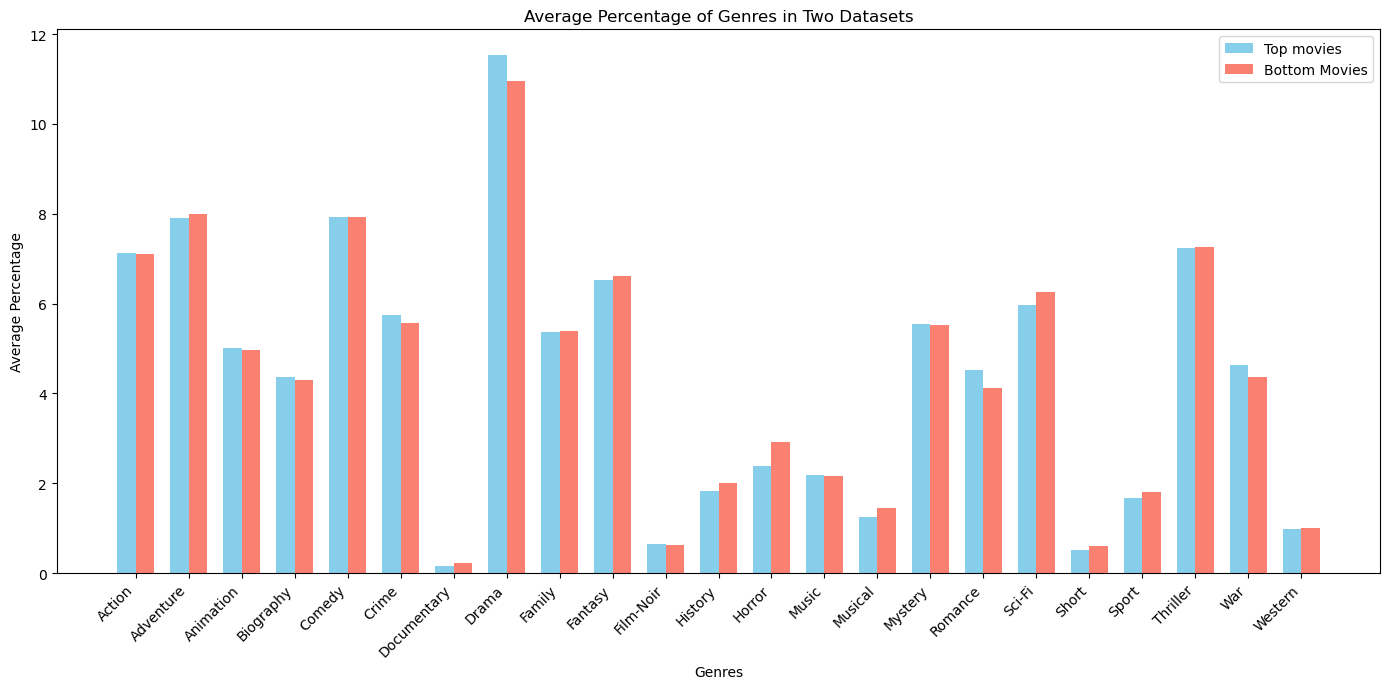

In [32]:
# Function to parse the 'All Genres' column into a dictionary
def parse_all_genres(row):
    if pd.isna(row):  # Handle empty or NaN cells
        return {}
    genre_dict = {}
    for item in row.split(', '):
        genre, percentage = item.split(': ')
        genre_dict[genre] = float(percentage.strip('%'))
    return genre_dict

# Load and process the first CSV file
file1 = 'top_movie_genre_percentages.csv'
df1 = pd.read_csv(file1)
df1['Parsed Genres'] = df1['All Genres'].apply(parse_all_genres)

# Load and process the second CSV file
file2 = 'bottom_movie_genre_percentages.csv'
df2 = pd.read_csv(file2)
df2['Parsed Genres'] = df2['All Genres'].apply(parse_all_genres)

# Function to calculate average percentages
def calculate_avg_genres(df):
    all_genres = {}
    for genres in df['Parsed Genres']:
        for genre, percentage in genres.items():
            all_genres[genre] = all_genres.get(genre, []) + [percentage]
    avg_genres = {genre: sum(percentages) / len(percentages) for genre, percentages in all_genres.items()}
    return avg_genres

# Calculate averages for both datasets
avg_genres_1 = calculate_avg_genres(df1)
avg_genres_2 = calculate_avg_genres(df2)

# Align genres for consistent plotting
all_genres = sorted(set(avg_genres_1.keys()).union(avg_genres_2.keys()))
avg_1 = [avg_genres_1.get(genre, 0) for genre in all_genres]
avg_2 = [avg_genres_2.get(genre, 0) for genre in all_genres]

# Plotting
x = np.arange(len(all_genres))  # X-axis positions
width = 0.35  # Width of the bars

plt.figure(figsize=(14, 7))

# Bars for the first dataset
plt.bar(x - width/2, avg_1, width, label='Top movies', color='skyblue')

# Bars for the second dataset
plt.bar(x + width/2, avg_2, width, label='Bottom Movies', color='salmon')

# Labels and formatting
plt.xticks(x, all_genres, rotation=45, ha='right')
plt.title('Average Percentage of Genres in Two Datasets')
plt.xlabel('Genres')
plt.ylabel('Average Percentage')
plt.legend()
plt.tight_layout()
plt.show()

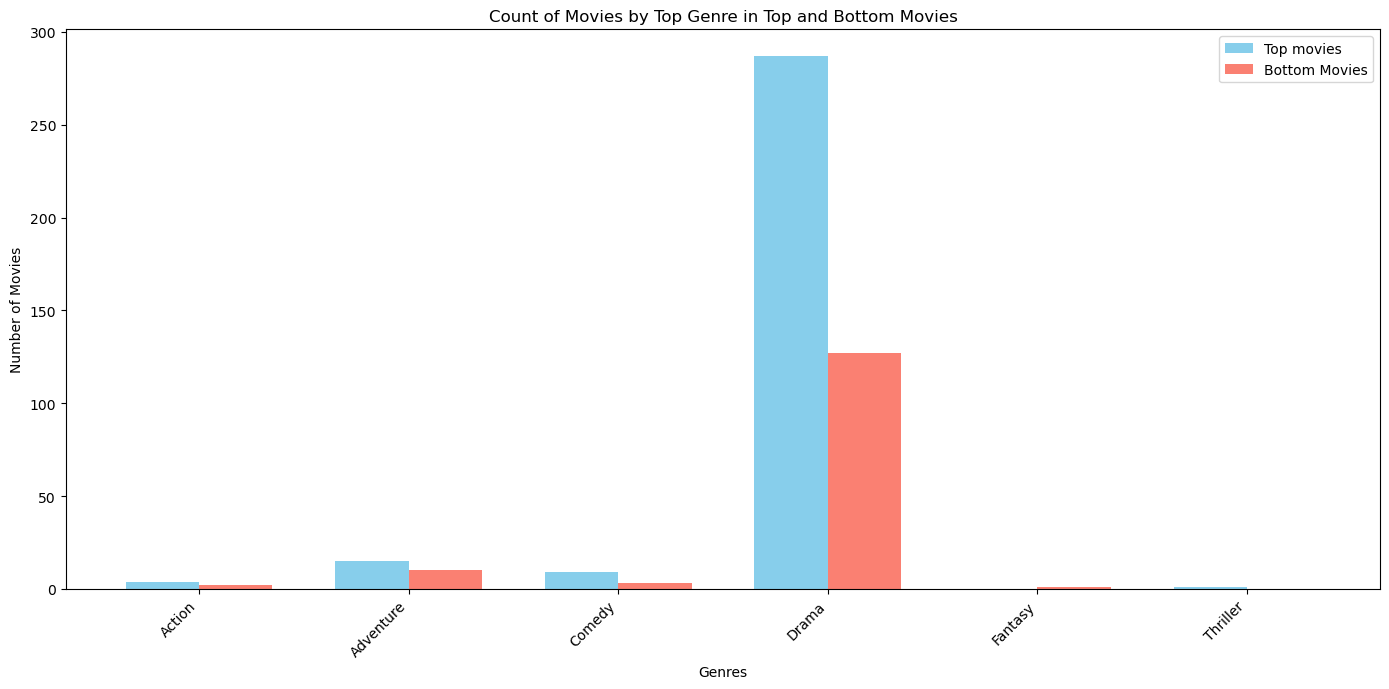

In [34]:
# Function to calculate top genre counts
def calculate_top_genre_counts(df):
    genre_counts = Counter()
    
    # Count occurrences of top genres
    for _, row in df.iterrows():
        top_genre = row["Top Genre"]
        if pd.notna(top_genre):  # Ensure there's a valid genre
            genre_counts[top_genre] += 1
    
    return genre_counts


# Calculate top genre counts for both datasets
top_genre_counts_1 = calculate_top_genre_counts(df1)  # For top movies
top_genre_counts_2 = calculate_top_genre_counts(df2)  # For bottom movies

# Align genres for consistent plotting
all_genres = sorted(set(top_genre_counts_1.keys()).union(top_genre_counts_2.keys()))
counts_1 = [top_genre_counts_1.get(genre, 0) for genre in all_genres]
counts_2 = [top_genre_counts_2.get(genre, 0) for genre in all_genres]

# Plotting
x = np.arange(len(all_genres))  # X-axis positions
width = 0.35  # Width of the bars

plt.figure(figsize=(14, 7))

# Bars for the first dataset (top movies)
plt.bar(x - width / 2, counts_1, width, label='Top movies', color='skyblue')

# Bars for the second dataset (bottom movies)
plt.bar(x + width / 2, counts_2, width, label='Bottom Movies', color='salmon')

# Labels and formatting
plt.xticks(x, all_genres, rotation=45, ha='right')
plt.title('Count of Movies by Top Genre in Top and Bottom Movies')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.legend()
plt.tight_layout()
plt.show()


<div class="alert alert-warning">
NEW MAPPING COUNTING ALL GENRES AND NUMBERS FOR EACH KEYWORD
</div>

**Step1: Normalize the Genre Values**

For each keyword in the dataset, normalize the genre values so their total adds up to **1**. This ensures that each keyword contributes proportionally to its associated genres.

Example Dataset:
| Keyword  | Drama | Biography | Crime | Thriller | Short | Action | Sci-Fi | War | Mystery | Comedy | Adventure | Fantasy | Horror |
|----------|-------|-----------|-------|----------|-------|--------|--------|-----|---------|--------|-----------|---------|--------|
| prison   | 18.0  | 5.0       | 10.0  | 5.0      | 1.0   | 2.0    | 2.0    | 4.0 | 2.0     | 4.0    | 3.0       | 1.0     | 1.0    |
| action   | 2.0   | 0.0       | 4.0   | 3.0      | 0.0   | 5.0    | 6.0    | 0.0 | 1.0     | 2.0    | 7.0       | 1.0     | 3.0    |

1. Calculate the Total for Each Keyword:  
   - **prison**: $18 + 5 + 10 + 5 + 1 + 2 + 2 + 4 + 2 + 4 + 3 + 1 + 1 = 58$
   - **action**: $2 + 0 + 4 + 3 + 0 + 5 + 6 + 0 + 1 + 2 + 7 + 1 + 3 = 34$
   
2. Normalize Each Value for Each Keyword:  
   - For **prison**:  
     - Drama: $\frac{18}{58} = 0.310$ 
     - Biography: $\frac{5}{58} = 0.086$  
     - Crime: $\frac{10}{58} = 0.172$ 
     - And so on...

   - For **action**:  
     - Drama: $\frac{2}{34} = 0.059$  
     - Biography: $\frac{0}{34} = 0.0$
     - Crime: $\frac{4}{34} = 0.118$ 
     - And so on...

Normalized Dataset:
| Keyword  | Drama  | Biography | Crime  | Thriller | Short  | Action | Sci-Fi | War   | Mystery | Comedy | Adventure | Fantasy | Horror |
|----------|--------|-----------|--------|----------|--------|--------|--------|-------|---------|--------|-----------|---------|--------|
| prison   | 0.310  | 0.086     | 0.172  | 0.086    | 0.017  | 0.034  | 0.034  | 0.069 | 0.034   | 0.069  | 0.052     | 0.017   | 0.017  |
| action   | 0.059  | 0.000     | 0.118  | 0.088    | 0.000  | 0.147  | 0.176  | 0.000 | 0.029   | 0.059  | 0.206     | 0.029   | 0.088  |


**Step 2: Process the Synopsis**
1. Split the synopsis into individual words.
2. For each word in the synopsis:
   - If it matches a keyword in the dataset, retrieve its normalized genre values.
   - Add these normalized values to the running total for each genre.

Example:

Synopsis:  *"prison action prison"*

- The word "prison" appears **twice**.
- The word "action" appears **once**.

Add Contributions for 'prison' (twice):  
- Drama: $2 \times 0.310 = 0.620$
- Biography: $2 \times 0.086 = 0.172$
- Crime: $2 \times 0.172 = 0.344$
- And so on...

Add Contributions for 'action' (once):  
- Drama: $0.059$  
- Biography: $0.000$ 
- Crime: $0.118$
- And so on...

Total Contributions:
| Genre     | Total Contribution |
|-----------|---------------------|
| Drama     | 0.620 + 0.059 = 0.679 |
| Biography | 0.172 + 0.000 = 0.172 |
| Crime     | 0.344 + 0.118 = 0.462 |
| And so on...


**Step 3: Calculate Genre Percentages**
1. Sum All Contributions:  
   $\text{Total} = 0.679 + 0.172 + 0.462 + 0.260 + 0.034 + 0.215 + 0.244 + \dots$
   
2. Calculate the Percentage for Each Genre:  
   - Drama: $\frac{0.679}{\text{Total}} \times 100$ 
   - Biography: $\frac{0.172}{\text{Total}} \times 100$ 
   - Crime: $\frac{0.462}{\text{Total}} \times 100$  
   - And so on...

Final Genre Percentages:
| Genre     | Percentage |
|-----------|------------|
| Drama     | 43.9%      |
| Biography | 12.2%      |
| Crime     | 24.4%      |
| Thriller  | 12.2%      |
| Short     | 2.4%       |
| Action    | 4.9%       |


In [49]:
# Step 1: Normalize the genre values for each keyword
def normalize_genres(df):
    normalized_mapping = {}
    for _, row in df.iterrows():
        keyword = row['Keyword']
        genre_values = row.iloc[1:]  # Exclude 'Keyword'
        genre_values = genre_values[genre_values > 0]  # Keep only non-zero genres
        total = genre_values.sum()
        normalized_mapping[keyword] = (genre_values / total).to_dict()  # Normalize
    return normalized_mapping

# Step 2: Process synopsis to calculate genre percentages
def calculate_genre_percentages(synopsis, keyword_genre_mapping):
    words = synopsis.split()  # Split synopsis into words
    genre_totals = Counter()
    
    # For each word in the synopsis
    for word in words:
        if word in keyword_genre_mapping:  # If the word is in the mapping
            for genre, value in keyword_genre_mapping[word].items():
                genre_totals[genre] += value  # Add the genre contribution
    
    # Convert totals into percentages
    total_contributions = sum(genre_totals.values())
    genre_percentages = {genre: (count / total_contributions) * 100 for genre, count in genre_totals.items()}
    return genre_percentages

# Step 3: Process all synopses and calculate genre percentage
def process_and_save_genre_percentages(synopses, keyword_genre_mapping, output_file):
    movie_genre_percentages = []

    for movie_name, synopsis in synopses.items():
        # Calculate percentages for the movie
        genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
        # Sort genres by percentage in descending order
        sorted_genres = sorted(genre_percentages.items(), key=lambda x: x[1], reverse=True)
        # Prepare data for saving
        movie_genre_percentages.append({
            "Movie": movie_name,
            "Top Genre": sorted_genres[0][0] if sorted_genres else None,  # Highest percentage genre
            "Top Percentage": sorted_genres[0][1] if sorted_genres else 0,  # Highest percentage
            "All Genres": ", ".join([f"{genre}: {percentage:.2f}%" for genre, percentage in sorted_genres])  # Full list
        })

    # Convert to DataFrame and save
    result_df = pd.DataFrame(movie_genre_percentages)
    result_df.to_csv(output_file, index=False)
    print(f"Genre percentages saved to {output_file}")

In [50]:
# Normalize the genre values
genre_df = pd.read_csv('merged_dictionary.csv')
normalized_mapping = normalize_genres(genre_df)

# Calculate genre percentages for a synopsis and save top movies
output_file_top = "NEW_top_movie_genre_percentages.csv"
process_and_save_genre_percentages(synopses_top, normalized_mapping, output_file_top)

# Check for example movie
movie_name = "12 Angry Men"
genre_percentages = calculate_genre_percentages(synopses_top[movie_name], normalized_mapping)
total_percentage = sum(genre_percentages.values())
print(f"Total percentage for '{movie_name}': {total_percentage:.2f}%")
print(f"Percentage for each genre: {genre_percentages}")

Genre percentages saved to NEW_top_movie_genre_percentages.csv
Total percentage for '12 Angry Men': 100.00%
Percentage for each genre: {'Drama': 26.381568015279, 'Biography': 2.3461602425532275, 'Crime': 11.128055825822877, 'Thriller': 8.960673261475536, 'Action': 4.304284413721322, 'Sci-Fi': 4.582361212785851, 'Mystery': 5.429027672960514, 'War': 2.4771309941270077, 'Comedy': 7.725559573346804, 'Adventure': 7.54522978509525, 'Fantasy': 4.887186783884123, 'Music': 0.7899018005514952, 'Animation': 3.2949282548164134, 'Family': 3.7841824876577967, 'Horror': 1.4215355487066015, 'Romance': 3.0769512733201188, 'History': 0.5663415758985628, 'Sport': 0.9933670671049956, 'Film-Noir': 0.10530736036476146, 'Western': 0.15401557711950975, 'Musical': 0.046231273408239716}


In [51]:
# Calculate genre percentages for a synopsis and save bottom movies
output_file_bottom = "NEW_bottom_movie_genre_percentages.csv"
process_and_save_genre_percentages(synopses_bottom, normalized_mapping, output_file_bottom)

# Check for example movie
movie_name = "Alone in the Dark"
genre_percentages = calculate_genre_percentages(synopses_bottom[movie_name], normalized_mapping)
total_percentage = sum(genre_percentages.values())
print(f"Total percentage for '{movie_name}': {total_percentage:.2f}%")
print(f"Percentage for each genre: {genre_percentages}")

Genre percentages saved to NEW_bottom_movie_genre_percentages.csv
Total percentage for 'Alone in the Dark': 100.00%
Percentage for each genre: {'Drama': 20.708174945864894, 'Romance': 4.018118325880846, 'Thriller': 7.222221248666262, 'Action': 8.232783298438177, 'Sci-Fi': 7.742528572349491, 'Adventure': 9.029854727763517, 'Fantasy': 5.330464338143604, 'War': 4.832293221617036, 'Mystery': 7.185236035205388, 'Biography': 1.455713558102795, 'Crime': 4.643772855221432, 'Comedy': 5.968018555878848, 'History': 0.5727581291642535, 'Horror': 5.072556760737612, 'Animation': 2.327935443752423, 'Family': 3.0589804226265125, 'Musical': 0.19316749763059976, 'Western': 1.4479802151035035, 'Sport': 0.15245409081025524, 'Music': 0.31694966626473486, 'Film-Noir': 0.48803809077781707}


Consider the top genre of each movie as its definitive genre. This means we use the "Top Genre" column from the datasets as the primary genre for each movie. 
Then, we calculate the total count of movies for each genre in both datasets: TOP and BOTTOM.
The chart shows how genres are distributed between the top and bottom movie categories.

Counter({'Drama': 308, 'Adventure': 5, 'Thriller': 2, 'Comedy': 1})
Counter({'Drama': 138, 'Comedy': 3, 'Fantasy': 1, 'Adventure': 1})


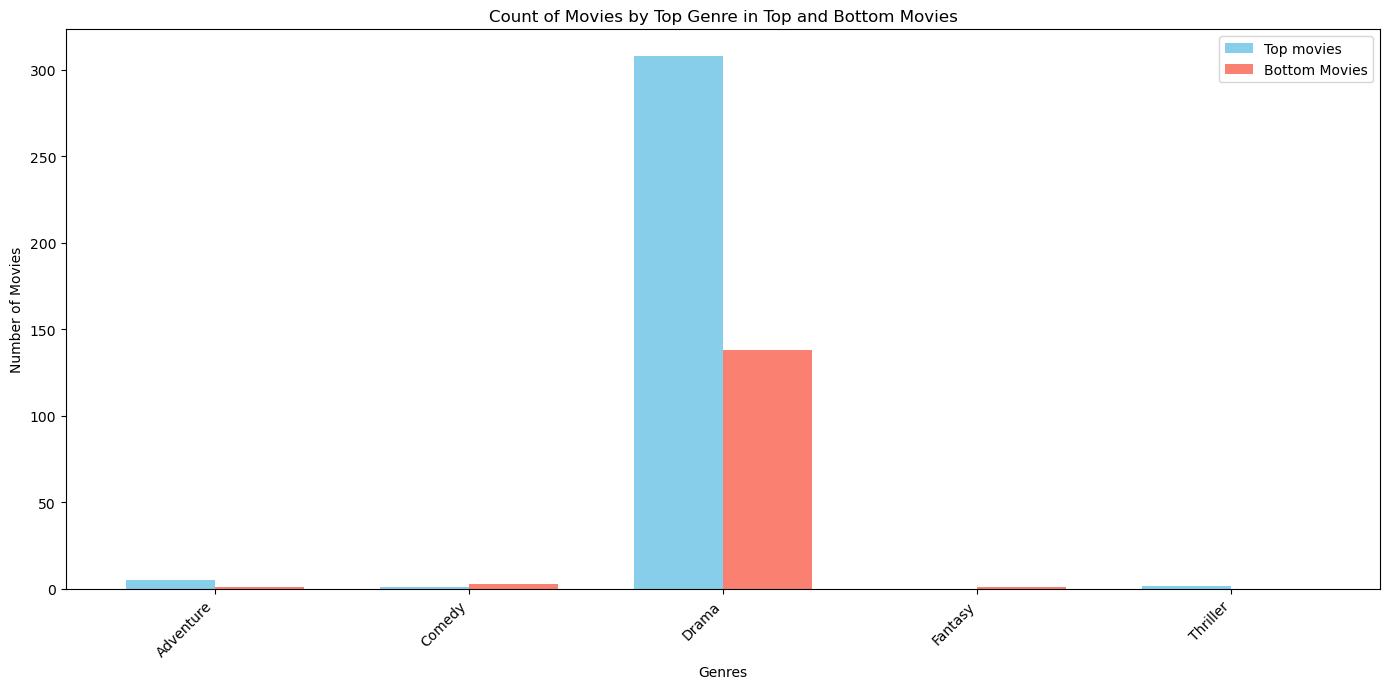

In [52]:
df1 = pd.read_csv("NEW_top_movie_genre_percentages.csv")
df2 = pd.read_csv("NEW_bottom_movie_genre_percentages.csv")

# Calculate top genre counts for both datasets
top_genre_counts_1 = calculate_top_genre_counts(df1)  # For top movies
top_genre_counts_2 = calculate_top_genre_counts(df2)  # For bottom movies
print(top_genre_counts_1)
print(top_genre_counts_2)

# Align genres for consistent plotting
all_genres = sorted(set(top_genre_counts_1.keys()).union(top_genre_counts_2.keys()))
counts_1 = [top_genre_counts_1.get(genre, 0) for genre in all_genres]
counts_2 = [top_genre_counts_2.get(genre, 0) for genre in all_genres]

# Plotting
x = np.arange(len(all_genres))  # X-axis positions
width = 0.35  # Width of the bars

plt.figure(figsize=(14, 7))

# Bars for the first dataset (top movies)
plt.bar(x - width / 2, counts_1, width, label='Top movies', color='skyblue')

# Bars for the second dataset (bottom movies)
plt.bar(x + width / 2, counts_2, width, label='Bottom Movies', color='salmon')

# Labels and formatting
plt.xticks(x, all_genres, rotation=45, ha='right')
plt.title('Count of Movies by Top Genre in Top and Bottom Movies')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.legend()
plt.tight_layout()
plt.show()

<div class="alert alert-warning">
MAPPING TAKING ONLY INTO ACCOUNT THE TOP GENRE FOR EACH KEYWORD.
</div>

Now we make the genre mapping of the keywords.

The create_keyword_genre_mapping function takes a DataFrame (genre_df) containing keywords and their scores for different genres and creates a mapping where each keyword is associated with the genre(s) that have the highest score for it. Here's how it works:

1. Iterating Through Rows: The function loops through each row of the DataFrame. Each row represents a keyword and its scores across various genres.

2. Finding the Maximum Score: For each row, the function finds the maximum score across all genres. This score indicates which genre(s) the keyword is most strongly associated with.

3. Identifying Genres with the Maximum Score: The genres that have the maximum score for the keyword are identified. If there’s a tie (two or more genres have the same score), all such genres are included.

4. Storing the Mapping: The keyword is stored as a key in the dictionary, with its value being a list of genres that have the highest score.

Below is an example:

If we have the following dictionary:

| **Keyword** | **Drama** | **Action** | **Thriller** | **Romance** |
|-------------|-----------|------------|--------------|-------------|
| **prison**  | 17.0      | 3.0        | 5.0          | 0.0         |
| **love**    | 10.0      | 0.0        | 0.0          | 10.0        |
| **survival**| 0.0       | 10.0       | 10.0         | 0.0         |

The associated genres for each keyword would be:
- **prison**: Drama
- **love** : Drama, Romance
- **survival**: Action, Thriller


In [54]:
def create_keyword_genre_mapping(genre_df):
    keyword_genre_mapping = {}
    
    # Loop through each row of the genre_df
    for _, row in genre_df.iterrows():
        keyword = row['Keyword']
        
        # Get the maximum score across all genres for this keyword
        max_score = row[1:].max()  # Get the maximum score (ignores the 'Keyword' column)

        # Find the genres that have the max score
        genres_with_max_score = row[1:][row[1:] == max_score].index.tolist()
        
        # Store the keyword and its associated genres
        keyword_genre_mapping[keyword] = genres_with_max_score
    
    return keyword_genre_mapping

# Example
merged_df = pd.read_csv('merged_dictionary.csv')

keyword_genre_mapping = create_keyword_genre_mapping(merged_df)

# Print the mapping for a sample keyword
sample_keyword = "love"
if sample_keyword in keyword_genre_mapping:
    print(f"Genres associated with '{sample_keyword}': {keyword_genre_mapping[sample_keyword]}")
else:
    print(f"'{sample_keyword}' not found in the keyword-genre mapping.")


Genres associated with 'love': ['Drama']


Calculate the percentage representation of different genres in a movie's synopsis based on genre-related keywords. 
Each keyword can be associated with one or more genres, and the calculation treats multi-genre keywords as contributing to each genre independently. 
Here's how it works:

1. **Keyword-Genre Mapping**:
   - A predefined dictionary links specific keywords to genres.
   - Example:
     ```python
     keyword_genre_mapping = {
         'alien': ['Sci-Fi', 'Horror'],
         'spaceship': ['Sci-Fi'],
         'terrorizing': ['Horror'],
         'masterpiece': ['Drama'],
     }
     ```

2. **Process Each Movie Synopsis**:
   - Clean the synopsis text (e.g., remove punctuation, convert to lowercase).
   - Identify unique words in the synopsis.
   - For each word, check if it's in the `keyword_genre_mapping`. If it is:
     - Add `1` to the count of each genre associated with the word.
     - Increment the total keyword count by the number of associated genres.

3. **Calculate Percentages**:
   - For each genre, calculate its percentage as:
   
     $\text{Percentage of Genre} = \left( \frac{\text{Genre Count}}{\text{Total Keywords}} \right) \times 100$

   - This ensures that all genre contributions sum to 100%.



In [55]:
def calculate_genre_percentages(synopsis, keyword_genre_mapping):
    # Clean the synopsis and split into words
    cleaned_synopsis = clean_text(synopsis)
    words = cleaned_synopsis.split()  # All words in the synopsis (not unique)
    #words = set(cleaned_synopsis.split())  # Unique words in the synopsis
    
    genre_counts = Counter()  # To store genre counts
    total_keywords = 0  # To store the total number of genre-related keywords found
    
    # For each word in the cleaned synopsis, check if it's a keyword and if so, count it in its genres
    for word in words:
        if word in keyword_genre_mapping:
            genres = keyword_genre_mapping[word]
            total_keywords += len(genres)  # Increment total for each genre match
            for genre in genres:
                genre_counts[genre] += 1
    
    # Calculate the genre percentages
    if total_keywords == 0:  # If no genre-related keywords are found
        return {genre: 0 for genre in genre_counts}
    
    genre_percentages = {genre: (count / total_keywords) * 100 for genre, count in genre_counts.items()}
    
    return genre_percentages


In [56]:
# Loop through all movies and calculate their genre percentages based on their synopses TOP
movie_genre_percentages = {}

for movie_name, synopsis in synopses_top.items():
    genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
    movie_genre_percentages[movie_name] = genre_percentages

# Preview the results for one movie
print(movie_genre_percentages.get('A Beautiful Mind', {}))


# Check if percentages sum 100
example_percentages = movie_genre_percentages.get('A Beautiful Mind', {})
total_percentage = sum(example_percentages.values())
print(f"Total percentage for 'A Beautiful Mind': {total_percentage:.2f}%")

{'Drama': 25.520833333333332, 'Action': 5.729166666666666, 'War': 3.6458333333333335, 'Mystery': 4.6875, 'Comedy': 9.375, 'Adventure': 8.854166666666668, 'Fantasy': 6.770833333333333, 'Animation': 5.208333333333334, 'Family': 6.770833333333333, 'Romance': 2.604166666666667, 'Biography': 4.166666666666666, 'History': 0.5208333333333333, 'Sci-Fi': 3.125, 'Thriller': 4.6875, 'Horror': 2.604166666666667, 'Crime': 2.083333333333333, 'Music': 1.5625, 'Sport': 1.5625, 'Documentary': 0.5208333333333333}
Total percentage for 'A Beautiful Mind': 100.00%


In [57]:
# Loop through all movies and calculate their genre percentages based on their synopses BOTTOM
movie_genre_percentages = {}

for movie_name, synopsis in synopses_bottom.items():
    genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
    movie_genre_percentages[movie_name] = genre_percentages

# Preview the results for one movie
print(movie_genre_percentages.get('Battlefield Earth', {}))

# Check if percentages sum 100
example_percentages = movie_genre_percentages.get('Battlefield Earth', {})
total_percentage = sum(example_percentages.values())
print(f"Total percentage for 'Battlefield Earth': {total_percentage:.2f}%")

{'Sci-Fi': 10.81081081081081, 'Adventure': 16.216216216216218, 'Animation': 9.45945945945946, 'Family': 9.45945945945946, 'Drama': 16.89189189189189, 'Sport': 0.6756756756756757, 'Action': 8.783783783783784, 'Fantasy': 7.4324324324324325, 'Horror': 0.6756756756756757, 'Thriller': 6.756756756756757, 'War': 2.027027027027027, 'Crime': 1.3513513513513513, 'Comedy': 5.405405405405405, 'Mystery': 1.3513513513513513, 'Western': 0.6756756756756757, 'Film-Noir': 0.6756756756756757, 'Biography': 0.6756756756756757, 'History': 0.6756756756756757}
Total percentage for 'Battlefield Earth': 100.00%


Create the CSV containing the genre percentages for all the movies.

1. Initialization: Creates an empty list movie_genre_percentages to store the processed results for each movie.

2. Loop Through Synopses:For each movie, the function calculates the percentage contribution of each genre to the movie’s synopsis using the calculate_genre_percentages function.

3. Sort Genres by Percentage: The genres are sorted in descending order of their percentages. This ensures that the most prominent genres appear first.

4. Organize Data for Each Movie: For each movie:
    - Top Genre: The genre with the highest percentage.
    - Top Percentage: The percentage value of the top genre.
    - All Genres: A string representation of all genres and their percentages in descending order (e.g., "Drama: 40.00%, Romance: 30.00%").

5. Save to a CSV File: The data is converted into a DataFrame and saved as a CSV file with the name provided in output_file.

Below there is an example:

| Movie          | Top Genre | Top Percentage | All Genres                                     |
|----------------|-----------|----------------|-----------------------------------------------|
| Alien          | Sci-Fi    | 60.00          | Sci-Fi: 60.00%, Action: 30.00%, Thriller: 10.00% |
| Titanic        | Romance   | 70.00          | Romance: 70.00%, Drama: 20.00%, History: 10.00% |
| The Matrix     | Sci-Fi    | 50.00          | Sci-Fi: 50.00%, Action: 40.00%, Thriller: 10.00% |
| Shawshank Redemption | Drama     | 80.00          | Drama: 80.00%, Crime: 15.00%, Biography: 5.00% |
| Inception      | Thriller  | 50.00          | Thriller: 50.00%, Sci-Fi: 40.00%, Action: 10.00% |


In [58]:
# Calculate genre percentages and organize from top to bottom for each film
def process_and_save_genre_percentages(synopses, keyword_genre_mapping, output_file):
    movie_genre_percentages = []

    for movie_name, synopsis in synopses.items():
        # Calculate percentages for the movie
        genre_percentages = calculate_genre_percentages(synopsis, keyword_genre_mapping)
        # Sort genres by percentage in descending order
        sorted_genres = sorted(genre_percentages.items(), key=lambda x: x[1], reverse=True)
        # Prepare data for saving
        movie_genre_percentages.append({
            "Movie": movie_name,
            "Top Genre": sorted_genres[0][0] if sorted_genres else None,  # Highest percentage genre
            "Top Percentage": sorted_genres[0][1] if sorted_genres else 0,  # Highest percentage
            "All Genres": ", ".join([f"{genre}: {percentage:.2f}%" for genre, percentage in sorted_genres])  # Full list
        })

    # Convert to DataFrame and save
    result_df = pd.DataFrame(movie_genre_percentages)
    result_df.to_csv(output_file, index=False)
    print(f"Genre percentages saved to {output_file}")

# Run the function and save the results
output_file = "top_movie_genre_percentages.csv"
process_and_save_genre_percentages(synopses_top, keyword_genre_mapping, output_file)

# Calculate genre percentages and organize from top to bottom for each film
output_file = "bottom_movie_genre_percentages.csv"
process_and_save_genre_percentages(synopses_bottom, keyword_genre_mapping, output_file)

Genre percentages saved to top_movie_genre_percentages.csv
Genre percentages saved to bottom_movie_genre_percentages.csv


Now we make the comparison.

Counter({'Drama': 306, 'Adventure': 6, 'Thriller': 2, 'Comedy': 1, 'Action': 1})
Counter({'Drama': 141, 'Adventure': 2})


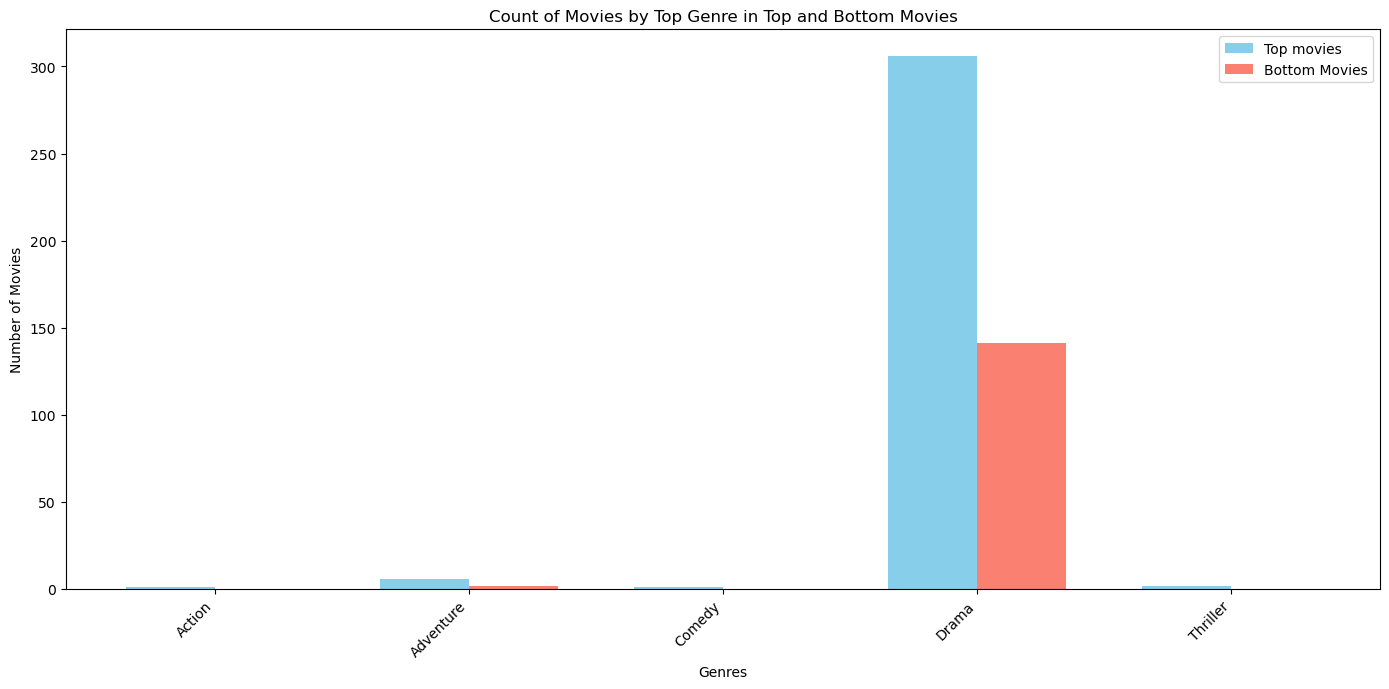

In [59]:
df1 = pd.read_csv("top_movie_genre_percentages.csv")
df2 = pd.read_csv("bottom_movie_genre_percentages.csv")

# Calculate top genre counts for both datasets
top_genre_counts_1 = calculate_top_genre_counts(df1)  # For top movies
top_genre_counts_2 = calculate_top_genre_counts(df2)  # For bottom movies
print(top_genre_counts_1)
print(top_genre_counts_2)

# Align genres for consistent plotting
all_genres = sorted(set(top_genre_counts_1.keys()).union(top_genre_counts_2.keys()))
counts_1 = [top_genre_counts_1.get(genre, 0) for genre in all_genres]
counts_2 = [top_genre_counts_2.get(genre, 0) for genre in all_genres]

# Plotting
x = np.arange(len(all_genres))  # X-axis positions
width = 0.35  # Width of the bars

plt.figure(figsize=(14, 7))

# Bars for the first dataset (top movies)
plt.bar(x - width / 2, counts_1, width, label='Top movies', color='skyblue')

# Bars for the second dataset (bottom movies)
plt.bar(x + width / 2, counts_2, width, label='Bottom Movies', color='salmon')

# Labels and formatting
plt.xticks(x, all_genres, rotation=45, ha='right')
plt.title('Count of Movies by Top Genre in Top and Bottom Movies')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.legend()
plt.tight_layout()
plt.show()